# Dacon Competition Project : Predict Market Sales

## Data field
* store_id : 상점의 고유 아이디
* card_id : 사용한 카드의 고유 아이디
* card_company : 비식별화된 카드 회사
* transacted_date: 거래 날짜
* transacted_time : 거래 시간 (시:분)
* installment_term : 할부 개월 수( 포인트 사용 시 (60개월 + 실제할부개월)을 할부개월수에 기재한다. )
* region : 상점의 지역
* type_of_business:상점의 업종
* amount : 거래액(단위는 원이 아닙니다)

## Index
### Step1. Data Load & Resampling
* 시계열 분석을 위한 date index로 변환
* 시간 단위로 나뉘어져 있는 데이터를 일 단위로 resampling
* Modeling을 위해 월 단위로 resampling


In [346]:
# jupyter notebook cell 너비 조절
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

# color
color = sns.color_palette()

In [368]:
# matplotlib한글폰트 깨짐문제 
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [369]:
# 지수표현 없애는 방법
pd.options.display.float_format = '{:.5f}'.format

In [345]:
# 기본
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.externals import joblib 
from sklearn.metrics import make_scorer

# 시계열
from fbprophet import Prophet
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

# 회귀분석
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Deep Neural Network
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

# 설정
%matplotlib inline
pd.options.display.max_columns = 400
pd.options.display.float_format = '{:.5f}'.format


ModuleNotFoundError: No module named 'fbprophet'

## Evaluate Metric
* MAE (Mean Absolute Error) : 절댓값 오차의 평균

$MAE=\frac{1}{𝑛}∑| 𝑦𝑖−𝑦̂𝑖|$
 
* validation을 위한 함수 생성 및 make scorer

In [3]:
def mae(prediction, correct):
    prediction = np.array(prediction)
    correct = np.array(correct)
    
    difference = correct - prediction
    abs_val = abs(difference)
    
    score = abs_val.mean()
    
    return score

mae_scorer = make_scorer(mae)
mae_scorer

make_scorer(mae)

## Issue
1) 예측해야 하는 범위는 3개월인데 데이터는 시간 단위로 나뉘어져 있음
* month 주기로 resampling 후 forecast 범위를 3개월로 지정하여 해결

2) 1967개의 store_id가 각각의 trend와 seasonality를 가지고 있음
* 같은 알고리즘에서 각 store_id별로 parameter를 조절한다.

3) 예측 날짜는 2019-03~2019-05로 동일하나, 제공 데이터의 마지막 날짜는 차이가 있다.
* 마지막 날짜부터 3개월만 예측하여 제출한다.(ex: store_id 111의 마지막 날짜는 2018-09월로 뒤 3개월인 2018-10~2018-12만 예측하여 제출)
* 예측 기간이 길어질수록 오차가 크게 발생하여 바로 뒤 3개월만 예측하는 것이 정확도가 높았음

# Step1. Data Load

In [4]:
df_train = pd.read_csv('./data/funda_train.csv')
df_sub = pd.read_csv('./data/submission.csv')
df_train['transacted_date'] = pd.to_datetime(df_train['transacted_date'])

print(df_train.shape)

(6556613, 9)


In [281]:
df_train['store_id'].unique()

array([   0,    1,    2, ..., 2134, 2135, 2136])

In [39]:
df_train['transacted_date'].dtype

dtype('<M8[ns]')

In [40]:
df_train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


In [19]:
# 각 컬럼의 유니크한 값이 몇개인지, 결측치 개수, 데이터타입, 유니크한 값 5개
### 아래 for문 풀어서 써보기 !
frame_info=[ ( col, len(df_train[col].unique()), df_train[col].isnull().sum(), df_train[col].dtype, df_train[col].unique()[:5] ) for col in df_train.columns]
df_info=pd.DataFrame(frame_info, columns=['name', 'num_of_unique', 'num_of_nan', 'type', 'front5_values'])
df_info

,name,num_of_unique,num_of_nan,type,front5_values
0,store_id,1967,0,int64,"[0, 1, 2, 4, 5]"
1,card_id,3950001,0,int64,"[0, 1, 2, 3, 4]"
2,card_company,8,0,object,"[b, h, c, a, f]"
3,transacted_date,1003,0,datetime64[ns],"[2016-06-01T00:00:00.000000000, 2016-06-02T00:..."
4,transacted_time,1440,0,object,"[13:13, 18:12, 18:52, 20:22, 11:06]"
5,installment_term,34,0,int64,"[0, 2, 3, 60, 4]"
6,region,181,2042766,object,"[nan, 서울 종로구, 충북 충주시, 부산 동래구, 경기 평택시]"
7,type_of_business,146,3952609,object,"[기타 미용업, nan, 의복 액세서리 및 모조 장신구 도매업, 한식 음식점업, 배..."
8,amount,30551,0,float64,"[1857.142857142857, 857.1428571428571, 2000.0,..."


### 시계열 분석을 위해 date 정보를 index로 변환

In [41]:
df_train = df_train.set_index('transacted_date')
df_train.head(3)

,store_id,card_id,card_company,transacted_time,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,
2016-06-01,0,0,b,13:13,0,NaN,기타 미용업,1857.142857
2016-06-01,0,1,h,18:12,0,NaN,기타 미용업,857.142857
2016-06-01,0,2,c,18:52,0,NaN,기타 미용업,2000.000000


### 시간 단위로 나뉘어져 있는 데이터를 일단위로 resampling
* 'store_id', 'region', 'type_of_business' 기존과 동일
* day_of_week : 각 요일을 나타내는 숫자, 월요일은 0 일요일은 6
* business_day : working day 여부, 1이면 working day 0이면 주말
* num_of_pay : 일 결제 건수, 'card_id'의 count로 생성
* num_of_revisit : 단골 방문 횟수, 'card_id'의 value 중 count가 2보다 큰(3 이상) value의 결제 건수
* installment_term : 일 총 할부 개월 수, 기존 installment_term의 합
* amount : 일 매출 액, 기존 amount의 합

> 시간별 데이터를 일별로 카운트하고 싶을 때
* resample(rule='d').count( ) <br>

> 시간별 데이터를 일별로 합계를 구하고 싶을 때
* resample(rule='d').sum( )

In [49]:
df_train[df_train.store_id==0]

,store_id,card_id,card_company,transacted_time,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,
2016-06-01,0,0,b,13:13,0,NaN,기타 미용업,1857.142857
2016-06-01,0,1,h,18:12,0,NaN,기타 미용업,857.142857
2016-06-01,0,2,c,18:52,0,NaN,기타 미용업,2000.000000
2016-06-01,0,3,a,20:22,0,NaN,기타 미용업,7857.142857
2016-06-02,0,4,c,11:06,0,NaN,기타 미용업,2000.000000
...,...,...,...,...,...,...,...,...
2019-02-28,0,1476,a,12:17,0,NaN,기타 미용업,2857.142857
2019-02-28,0,1719,a,16:20,0,NaN,기타 미용업,6428.571429
2019-02-28,0,1791,b,16:56,0,NaN,기타 미용업,7142.857143


#### resample() 함수
    * resample('d') 는 '년-월-일 시간:분:초' 의 시계열 index를 1일 단위의 동일 간격별로 데이터를 뽑으라는 뜻
#### insert() 함수
    * insert(a, b)는 리스트의 a번째 위치에 b를 삽입하는 함수이다.
#### dayofweek
    * date정보를 index로 변환했기 때문에 
    * df_train.index.dayofweek를 하면 각 요일을 나타내는 숫자 출력됨

In [139]:
df_train.index.dayofweek

Int64Index([2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
            ...
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
           dtype='int64', name='transacted_date', length=6556613)

In [69]:
df_train[df_train.store_id==0]['card_id'].resample(rule='d').count().rename('num_of_pay')

transacted_date
2016-06-01    4
2016-06-02    7
2016-06-03    3
2016-06-04    7
2016-06-05    3
             ..
2019-02-24    6
2019-02-25    6
2019-02-26    0
2019-02-27    5
2019-02-28    6
Freq: D, Name: num_of_pay, Length: 1003, dtype: int64

In [90]:
df_train[df_train.store_id==0].card_id.value_counts().reset_index().query("card_id >2")["index"].values[:10]

array([ 32, 855,  44, 669, 898, 138, 480, 560, 346, 595])

In [95]:
df_train[df_train.card_id.isin(df_train[df_train.store_id==0].card_id.value_counts().reset_index().query("card_id >2")["index"].values)].card_id

transacted_date
2016-06-01       0
2016-06-01       1
2016-06-01       2
2016-06-01       3
2016-06-02       4
              ... 
2018-04-28    1248
2017-10-04    1252
2017-12-22     117
2018-03-12     488
2017-02-11     707
Name: card_id, Length: 2877, dtype: int64

In [98]:
df_train[df_train.store_id==0][['installment_term','amount']].resample(rule='d').sum()

,installment_term,amount
transacted_date,,
2016-06-01,0,12571.428571
2016-06-02,0,40571.428571
2016-06-03,0,18142.857143
2016-06-04,0,31714.285714
2016-06-05,0,10428.571429
...,...,...
2019-02-24,0,38571.428571
2019-02-25,3,39714.285714
2019-02-26,0,0.000000


In [122]:
df_train[df_train.store_id==0].type_of_business

transacted_date
2016-06-01    기타 미용업
2016-06-01    기타 미용업
2016-06-01    기타 미용업
2016-06-01    기타 미용업
2016-06-02    기타 미용업
               ...  
2019-02-28    기타 미용업
2019-02-28    기타 미용업
2019-02-28    기타 미용업
2019-02-28    기타 미용업
2019-02-28    기타 미용업
Name: type_of_business, Length: 4481, dtype: object

In [132]:
pd.concat([pd.DataFrame(),df_train[df_train.store_id==0].type_of_business],axis=1)

,type_of_business
2016-06-01,기타 미용업
2016-06-01,기타 미용업
2016-06-01,기타 미용업
2016-06-01,기타 미용업
2016-06-02,기타 미용업
...,...
2019-02-28,기타 미용업
2019-02-28,기타 미용업
2019-02-28,기타 미용업
2019-02-28,기타 미용업


In [144]:
def resample_day(train_df):
    df_day = pd.DataFrame()
    for i in train_df.store_id.unique():
        df_num = train_df[train_df.store_id == i]  # store_id별 데이터

        count_cols = df_num['card_id'].resample(rule='d').count().rename('num_of_pay')  # 일별로 card_id의 개수를 카운팅해서 '일 거래 횟수' 확인
        # 'card_id' value count가 2보다 크면 단골인 것으로 판단하고 단골 방문 횟수 확인
        revisit_idx = df_num.card_id.value_counts().reset_index().query("card_id > 2")["index"].values   # value count가 2보다 큰 card_id를 가져옴.
        revisit_ct = df_num[df_num.card_id.isin(revisit_idx)].card_id.resample(rule='d').count().rename('num_of_revisit')    # 단골 방문횟수 
        sum_cols = df_num[['installment_term', 'amount']].resample(rule='d').sum() # 할부 개월수와 매출액은 일 단위로 합

        df_num_day = pd.concat([count_cols, revisit_ct, sum_cols], axis=1)

        df_num_day.insert(0, 'store_id', i)   # 첫번째 컬럼에 store_id를 삽입
        df_num_day.insert(4, 'region', df_num[df_num.store_id == i].region.unique()[0])    # 다섯번째 컬럼에 region을 삽입
        df_num_day.insert(5, 'type_of_business', df_num[df_num.store_id == i].type_of_business.unique()[0])  # 여섯번째 컬럼에 type_of_business 삽입

        df_day = pd.concat([df_day, df_num_day], axis=0)   # 데이터프레임 concat
        
    df_day.insert(1, 'day_of_week', df_day.index.dayofweek)
    df_day.insert(2, 'business_day', df_day.day_of_week.replace({0:1, 2:1, 3:1, 4:1, 5:0, 6:0}).values)
    df_day.num_of_revisit.fillna(0, inplace=True)
    
    return df_day

In [145]:
%%time
df_day = resample_day(df_train)

CPU times: user 2min 35s, sys: 1min 24s, total: 3min 59s
Wall time: 4min 5s


In [148]:
df_day = resample_day(df_train)

In [149]:
df_day.head()

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.0,0,NaN,기타 미용업,12571.428571
2016-06-02,0,3,1,7,3.0,0,NaN,기타 미용업,40571.428571
2016-06-03,0,4,1,3,2.0,0,NaN,기타 미용업,18142.857143
2016-06-04,0,5,0,7,3.0,0,NaN,기타 미용업,31714.285714
2016-06-05,0,6,0,3,3.0,0,NaN,기타 미용업,10428.571429


In [150]:
# 시간별로 있던 데이터를 일별로 만들었더니 Nan값 줄어듬.
df_day.isnull().sum()

store_id                  0
day_of_week               0
business_day              0
num_of_pay                0
num_of_revisit            0
installment_term          0
region               629927
type_of_business    1087791
amount                    0
dtype: int64

In [151]:
df_day.to_csv('./data/funda_train_day.csv')

In [152]:
df_day = pd.read_csv('./data/funda_train_day.csv')
df_day['transacted_date'] = pd.to_datetime(df_day['transacted_date'])
df_day = df_day.set_index('transacted_date')

각 column간 상관 관계 확인

In [153]:
daily_corr = df_day.corr()
daily_corr

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,amount
store_id,1.000000,-0.000040,0.000014,0.042367,0.008061,-0.012184,-0.018348
day_of_week,-0.000040,1.000000,-0.790518,0.016719,-0.038692,-0.013954,-0.021503
business_day,0.000014,-0.790518,1.000000,-0.004598,0.057214,0.015303,0.029468
num_of_pay,0.042367,0.016719,-0.004598,1.000000,0.701121,0.094140,0.265251
num_of_revisit,0.008061,-0.038692,0.057214,0.701121,1.000000,0.071132,0.260674
installment_term,-0.012184,-0.013954,0.015303,0.094140,0.071132,1.000000,0.267498
amount,-0.018348,-0.021503,0.029468,0.265251,0.260674,0.267498,1.000000


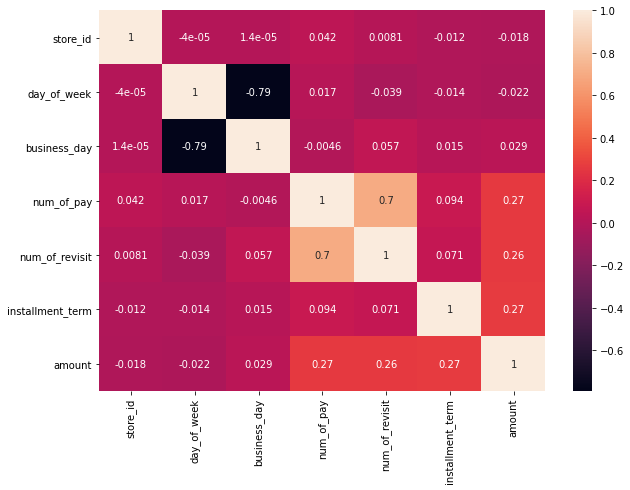

In [154]:
fig,ax=plt.subplots()
fig.set_size_inches(10,7)
sns.heatmap(daily_corr,annot=True)

### Modeling을 위해 Month 단위로 resampling

In [155]:
df_day.head(3)

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.0,0,NaN,기타 미용업,12571.428571
2016-06-02,0,3,1,7,3.0,0,NaN,기타 미용업,40571.428571
2016-06-03,0,4,1,3,2.0,0,NaN,기타 미용업,18142.857143


In [170]:
df_day.tail(3)

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2019-02-26,2136,1,1,6,1.0,0,제주 제주시,기타 주점업,47142.857143
2019-02-27,2136,2,1,10,1.0,0,제주 제주시,기타 주점업,65071.428571
2019-02-28,2136,3,1,15,7.0,0,제주 제주시,기타 주점업,65857.142857


In [164]:
from dateutil.relativedelta import relativedelta

In [212]:
df_day[df_day.store_id==0].index[0] 

Timestamp('2016-06-01 00:00:00')

In [218]:
# 2016-06-01 에서 한달전 데이터는 2016-05-01
df_day[df_day.store_id==0].index[0] - relativedelta(months=1)

Timestamp('2016-05-01 00:00:00')

In [172]:
# pd.date_range에 시작날짜와 끝 날짜 지정.
pd.date_range("2018-4-1", "2018-4-5")

DatetimeIndex(['2018-04-01', '2018-04-02', '2018-04-03', '2018-04-04',
               '2018-04-05'],
              dtype='datetime64[ns]', freq='D')

In [165]:
# 2016-06-01 로부터 한달 전
pd.date_range(start=(df_day[df_day.store_id==0].index[0] - relativedelta(months=1)), end=(df_day[df_day.store_id==0].index[0]- relativedelta(months=1)))

DatetimeIndex(['2016-05-01'], dtype='datetime64[ns]', freq='D')

In [171]:
# 2019-02-28 로부터 한달 후
pd.date_range(start=(df_day[df_day.store_id==0].index[-1] + relativedelta(months=1)), end=(df_day[df_day.store_id==0].index[-1]+ relativedelta(months=1)))

DatetimeIndex(['2019-03-28'], dtype='datetime64[ns]', freq='D')

In [174]:
# 한달전, 한달후 row를 위아래로 추가.
pd.concat([pd.DataFrame(index=pd.date_range(start=(df_day[df_day.store_id==0].index[0] - relativedelta(months=1)), end=(df_day[df_day.store_id==0].index[0] - relativedelta(months=1)))),
          df_day[df_day.store_id==0], 
          pd.DataFrame(index=pd.date_range(start=(df_day[df_day.store_id==0].index[-1] + relativedelta(months=1)), end=(df_day[df_day.store_id==0].index[-1]+ relativedelta(months=1))))])

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
2016-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-01,0.0,2.0,1.0,4.0,4.0,0.0,NaN,기타 미용업,12571.428571
2016-06-02,0.0,3.0,1.0,7.0,3.0,0.0,NaN,기타 미용업,40571.428571
2016-06-03,0.0,4.0,1.0,3.0,2.0,0.0,NaN,기타 미용업,18142.857143
2016-06-04,0.0,5.0,0.0,7.0,3.0,0.0,NaN,기타 미용업,31714.285714
...,...,...,...,...,...,...,...,...,...
2019-02-25,0.0,0.0,1.0,6.0,3.0,3.0,NaN,기타 미용업,39714.285714
2019-02-26,0.0,1.0,1.0,0.0,0.0,0.0,NaN,기타 미용업,0.000000
2019-02-27,0.0,2.0,1.0,5.0,2.0,0.0,NaN,기타 미용업,9857.142857
2019-02-28,0.0,3.0,1.0,6.0,4.0,0.0,NaN,기타 미용업,22714.285714


In [208]:
# day_of_week(요일) 데이터가 기존에는 일별로 되어있었음.
df_day[df_day.store_id==0][df_day[df_day.store_id==0].amount!=0].day_of_week[:10]

transacted_date
2016-06-01    2
2016-06-02    3
2016-06-03    4
2016-06-04    5
2016-06-05    6
2016-06-06    0
2016-06-09    3
2016-06-10    4
2016-06-11    5
2016-06-12    6
Name: day_of_week, dtype: int64

In [205]:
# day_of_week(요일) 데이터를 월별로 카운트
df_day[df_day.store_id==0][df_day[df_day.store_id==0].amount!=0].day_of_week.resample(rule='m').count().rename('real_tot_day')[:10]  

transacted_date
2016-06-30    25
2016-07-31    26
2016-08-31    24
2016-09-30    25
2016-10-31    26
2016-11-30    23
2016-12-31    27
2017-01-31    20
2017-02-28    23
2017-03-31    23
Freq: M, Name: real_tot_day, dtype: int64

In [210]:
# 한달 간의 평일수 합계 (주말 제외)
df_day[df_day.store_id==0][df_day[df_day.store_id==0].amount!=0].business_day.resample(rule='m').sum().rename('real_business_day')[:10]  

transacted_date
2016-06-30    17
2016-07-31    16
2016-08-31    16
2016-09-30    19
2016-10-31    16
2016-11-30    15
2016-12-31    18
2017-01-31    15
2017-02-28    15
2017-03-31    15
Freq: M, Name: real_business_day, dtype: int64

In [239]:
df_day[df_day.store_id==0].index[0].strftime('%Y-%m')

'2016-06'

In [224]:
import datetime as dt

In [240]:
### 질문 => 한달전, 한달후 row를 추가하는이유 ? 
##### sum해도 되는것들은 그냥 월별로 집계했고, 실제 매출이 발생한 요일수랑 working day 수 구할때만 고려한 이유.
def resample_month(frame_day):
    sum_cols=['num_of_pay','num_of_revisit','installment_term','amount']
    
    df_monthly=pd.DataFrame()
    
    for i in frame_day.store_id.unique():
        df_set=frame_day[frame_day.store_id==i]
        
        # nan값이 발생하는 경우를 없애기 위해 이전, 이후 달에 대한 정보를 추가한 후 제거
        prev_date= pd.date_range(start=(df_set.index[0] - relativedelta(months=1)), end=(df_set.index[0]- relativedelta(months=1)))    # start와 end날짜가 같으면 날짜 하나만 나옴.
        add_date = pd.date_range(start=(df_set.index[-1] + relativedelta(months=1)), end=(df_set.index[-1] + relativedelta(months=1)))
        df_set = pd.concat([pd.DataFrame(index=prev_date), df_set, pd.DataFrame(index=add_date)], axis=0)
        
        ### 이부분 에러나서 수정 : df_set.loc[dt.strftime(df_set.index[0], '%Y-%m'), :] = 1    =====> df_set.loc[df_set.index[0].strftime( '%Y-%m'), :] = 1 
        df_set.loc[df_set.index[0].strftime( '%Y-%m'), :] = 1    # 한달 이전값들을 모두 1로 
        df_set.loc[df_set.index[-1].strftime('%Y-%m'), :] = 1    # 한달 이후값들을 모두 1로
        
        tot_day=df_set[df_set.amount!=0].day_of_week.resample(rule='m').count().rename('real_tot_day') # 매출이 0제외 후, 실제 매출이 발생한 요일 수만 카운트.(즉,30일보다 작을수있음)
        business=df_set[df_set.amount!=0].business_day.resample(rule='m').sum().rename('real_business_day') # 주말 제외한 평일(working day) 수 합계
        
        # 새로 추가한 한달전, 한달 후 데이터를 drop
        business= business.drop([business.index[0], business.index[-1]], axis=0)   # 새로추가한 한달전 row와 한달후 row를 삭제
        tot_day = tot_day.drop([tot_day.index[0], tot_day.index[-1]], axis=0) 
        df_set = df_set.drop([df_set.index[0], df_set.index[-1]], axis=0)
        
        df = pd.concat([tot_day, business, df_set[sum_cols].resample(rule='m').sum()],axis=1)
        
        df.insert(0, 'store_id',i)    # 첫번째 컬럼에 store_id값 넣음
        df.insert(6, 'region', df_set.region.values[0])   # 일곱번째 컬럼에 region값 넣음.
        df.insert(7, 'type_of_business',df_set.type_of_business.values[0])
        
        df_monthly= pd.concat([df_monthly, df],axis=0)   # dataframe으로 만들어놓은 df_monthly변수와 concat으로 붙여서 최종셋 만듬.
    return df_monthly

In [241]:
df_month = resample_month(df_day)

In [242]:
df_month

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
2016-06-30,0,25,17.0,145.0,77.0,13.0,NaN,기타 미용업,7.470000e+05
2016-07-31,0,26,16.0,178.0,105.0,24.0,NaN,기타 미용업,1.005000e+06
2016-08-31,0,24,16.0,171.0,97.0,69.0,NaN,기타 미용업,8.715714e+05
2016-09-30,0,25,19.0,160.0,103.0,15.0,NaN,기타 미용업,8.978571e+05
2016-10-31,0,26,16.0,167.0,115.0,9.0,NaN,기타 미용업,8.354286e+05
...,...,...,...,...,...,...,...,...,...
2018-10-31,2136,31,23.0,338.0,86.0,0.0,제주 제주시,기타 주점업,2.012214e+06
2018-11-30,2136,28,20.0,356.0,87.0,0.0,제주 제주시,기타 주점업,2.135429e+06
2018-12-31,2136,31,21.0,403.0,109.0,0.0,제주 제주시,기타 주점업,2.427429e+06
2019-01-31,2136,31,23.0,297.0,74.0,3.0,제주 제주시,기타 주점업,1.873643e+06


In [243]:
df_month.isnull().sum()

store_id                 0
real_tot_day             0
real_business_day        0
num_of_pay               0
num_of_revisit           0
installment_term         0
region               20900
type_of_business     36048
amount                   0
dtype: int64

In [244]:
# 전체대비 null값의 비중 확인.
print("rate of 'region' :" , df_month.region.isnull().sum() / len(df_month))
print("rate of 'type_of_business' :" , df_month.type_of_business.isnull().sum() / len(df_month))

rate of 'region' : 0.34310104243618156
rate of 'type_of_business' : 0.5917754247722236


* 각각 34%, 59%에 이르는 null 값을 채우는 것은 너무 어렵고 채워도 오차가 클 것으로 예상되어 'region'과 'type_of_business' 삭제

In [247]:
df_month = df_month.drop(['region', 'type_of_business'], axis=1)
df_month.isnull().sum()

store_id             0
real_tot_day         0
real_business_day    0
num_of_pay           0
num_of_revisit       0
installment_term     0
amount               0
dtype: int64

In [248]:
df_month.to_csv('./data/funda_train_month.csv')

In [249]:
df_month=pd.read_csv('./data/funda_train_month.csv')

In [254]:
df_month.rename(columns={'Unnamed: 0' : 'transacted_date'}, inplace=True)
df_month['transacted_date'] = pd.to_datetime(df_month['transacted_date'])

In [257]:
df_month = df_month.set_index('transacted_date')

In [259]:
print(df_month.shape)
df_month.head()

(60915, 7)


,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
transacted_date,,,,,,,
2016-06-30,0,25,17.0,145.0,77.0,13.0,7.470000e+05
2016-07-31,0,26,16.0,178.0,105.0,24.0,1.005000e+06
2016-08-31,0,24,16.0,171.0,97.0,69.0,8.715714e+05
2016-09-30,0,25,19.0,160.0,103.0,15.0,8.978571e+05
2016-10-31,0,26,16.0,167.0,115.0,9.0,8.354286e+05


# Step2. EDA

In [260]:
df_month.describe()

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
count,60915.000000,60915.000000,60915.000000,60915.000000,60915.000000,60915.000000,6.091500e+04
mean,1050.484281,21.069868,15.896397,107.635443,40.011360,14.875400,1.123188e+06
std,617.483196,7.753269,5.631356,101.244129,43.881331,33.421611,1.753567e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.142857e+05
25%,515.000000,16.000000,12.000000,32.000000,11.000000,0.000000,3.396429e+05
50%,1039.000000,23.000000,17.000000,73.000000,26.000000,3.000000,7.107143e+05
75%,1587.000000,28.000000,21.000000,159.000000,54.000000,14.000000,1.344650e+06
max,2136.000000,31.000000,23.000000,2186.000000,2154.000000,1125.000000,6.142932e+07


Skewness: 0.48245510908400735


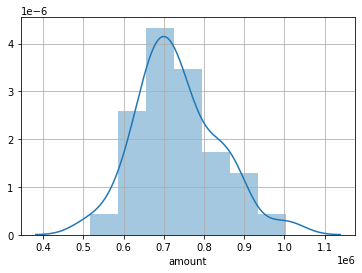

Skewness: 0.5102521050694732


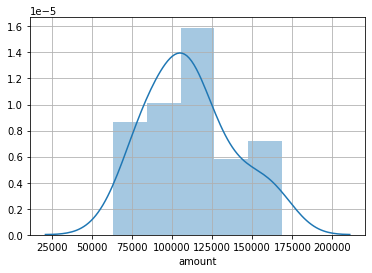

Skewness: 0.9982599271676977


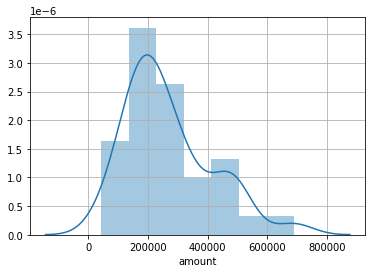

In [272]:
for i in df_month.store_id.unique()[:3]:
    print("Skewness:" ,df_month[df_month.store_id==i].amount.skew())
    sns.distplot(df_month[df_month.store_id==i].amount)
    plt.grid()
    plt.show()

비대칭도
* 비대칭도또는 왜도는 실수 값 확률 변수의 확률 분포 비대칭성을 나타내는 지표
* 왜도가 음수일 경우에는 확률밀도함수의 왼쪽 부분에 긴 꼬리를 가지며 중앙값을 포함한 자료가 오른쪽에 더 많이 분포해 있다. 
* 왜도가 양수일 때는 확률밀도함수의 오른쪽 부분에 긴 꼬리를 가지며 자료가 왼쪽에 더 많이 분포해 있다는 것을 나타낸다. 
* 평균과 중앙값이 같으면 왜도는 0이 된다.
* 비대칭도가 store_id마다 다름.

-0.5308009496851174


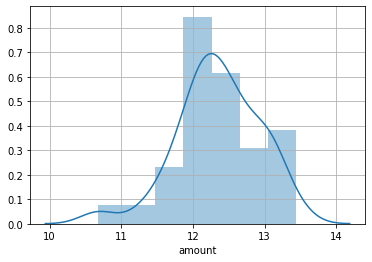

In [274]:
print(np.log(df_month[df_month.store_id==2].amount).skew())
sns.distplot(np.log(df_month[df_month.store_id==2].amount))
plt.grid()
plt.show()

* store_id 가 2인경우의 분포가 외도가 양수인, 왼쪽으로 치우친 형태였는데 , 로그 취한후에는 외도가 음수로 오른쪽으로 치우친 형태로 변형.

### 각 변수의 value 분포 시각화

In [285]:
pd.melt(df_month, value_vars=df_month.columns[1:])

,variable,value
0,real_tot_day,2.500000e+01
1,real_tot_day,2.600000e+01
2,real_tot_day,2.400000e+01
3,real_tot_day,2.500000e+01
4,real_tot_day,2.600000e+01
...,...,...
365485,amount,2.012214e+06
365486,amount,2.135429e+06
365487,amount,2.427429e+06
365488,amount,1.873643e+06


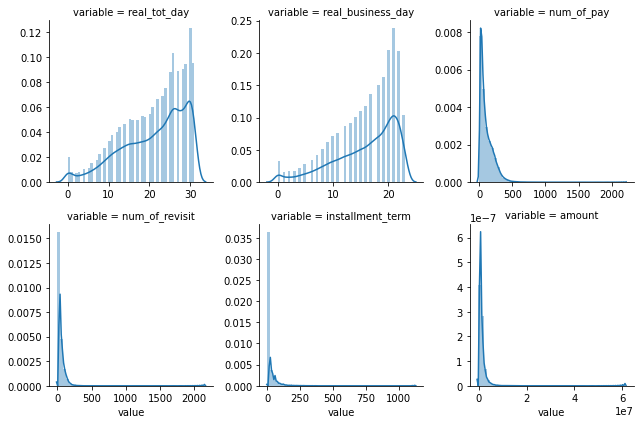

In [292]:
# 첫번째 컬럼에는 변수명을, 두번째 컬럼에는 변수에 해당하는 값을 넣은 데이터프레임으로 변수 종류별로 그래프 그릴 수 있음.
f = pd.melt(df_month, value_vars=df_month.columns[1:])
g=sns.FacetGrid(f, col='variable',col_wrap=3, sharex=False, sharey=False)
g.map(sns.distplot,"value")
plt.show()

### 같은 기간 동안 여러 상점 매출의 추이 및 스케일 확인(0~7)
* 각 store_id별로 다른 trend와 seasonality, scale을 가지는 것을 확인할 수 있음

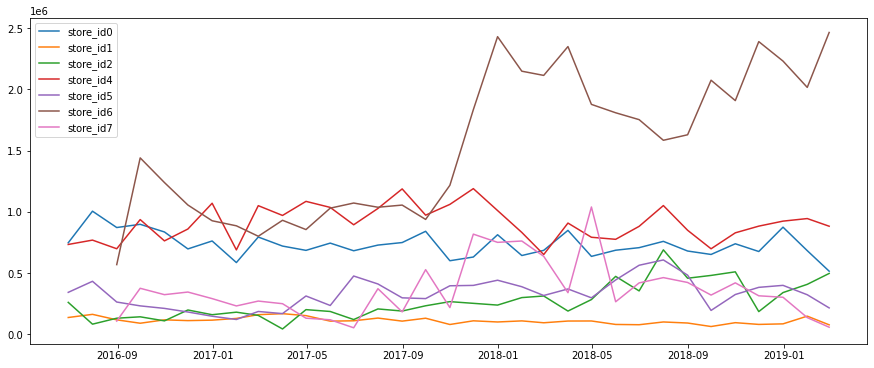

In [303]:
plt.figure(figsize=(15,6))
for i in df_month.store_id.unique()[:7]:
    plt.plot(df_month[df_month.store_id==i].index,  df_month[df_month.store_id==i].amount, label='store_id{}'.format(i))
plt.legend()

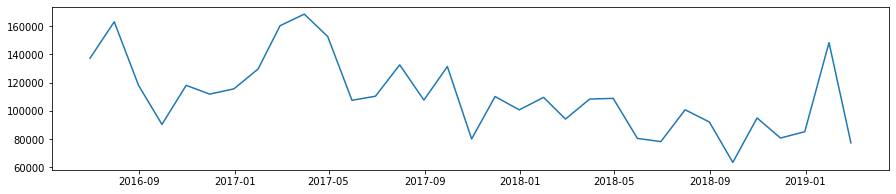

In [304]:
plt.figure(figsize=(15, 3))
plt.plot(df_month[df_month.store_id == 1].index, df_month[df_month.store_id == 1].amount)

### 다른변수들이 'amount'와 같은 pattern을 가지는 지 확인

In [311]:
def plot_model_graph(data_frame, store_num, idx_col, y_cols):
    df_set = data_frame[data_frame.store_id == store_num]
    
    fig, ax1 = plt.subplots(figsize=(15, 3))
    ax1.set_xlabel("{}".format(idx_col))
    ax1.set_ylabel("{}".format(y_cols[0])).set_color(color='tab:blue')
    ax1.plot(df_set.index, df_set[y_cols[0]].values, color='tab:blue')
    
    for i in range(1, len(y_cols)):
        ax2 = ax1.twinx()
        ax2.set_ylabel("{}".format(y_cols[i])).set_color(color='C{}'.format(i))
        ax2.plot(df_set.index, df_set[y_cols[i]].values, color='C{}'.format(i))
        ax2.spines['right'].set_position(('outward', (60*(i-1))))

    fig.tight_layout()
    plt.show()

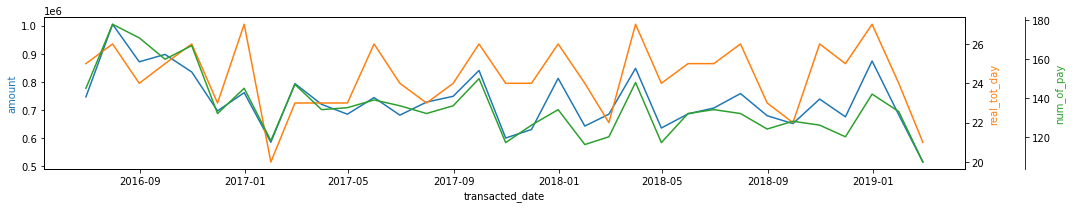

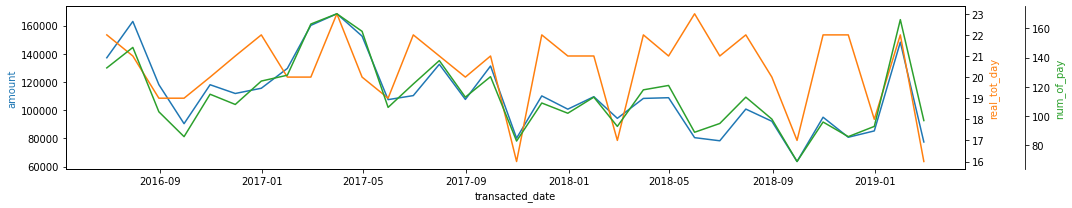

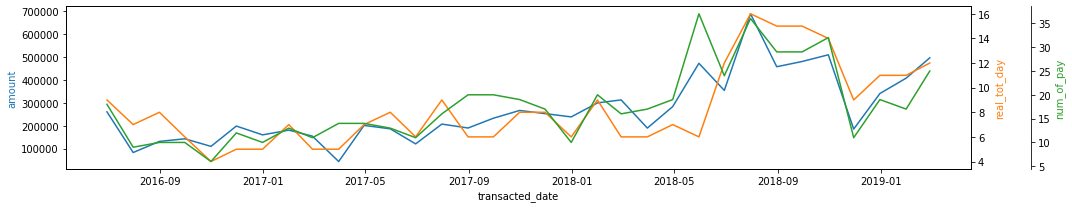

In [312]:
for i in df_month.store_id.unique()[:3]:
    plot_model_graph(df_month, i, 'transacted_date', ['amount', 'real_tot_day', 'num_of_pay'])

------------------------------------------------------------------------------------------
# Step3. Modeling - Time Series
[참고] https://otexts.com/fppkr/moving-averages.html

### 5가지 시계열 방법론 적용
> #### 1. 단순이동평균 (Simple Moving Average)
> #### 2. 지수이동평균 (Exponential Moving Average)
> #### 3. 지수 평활법 (Exponential Smoothing)
> * 3-1. Simple Exponential Smoothing
> * 3-2. Holt's Exponential Smoothing
> * 3-3. Holt-winter's Exponential Smoothing

> #### 4. ARMA
> #### 5. ARIMA



--------------------------------------------------------------------------------
## [ 3가지 이동평균 ]

### a. 단순이동평균 (Simple Moving Average)
> n1 , n2, n3 가 존재한다고 가정하면, (n1 + n2 + n3) / 3 입니다.
> * 단순이동평균은 특정 기간 동안의 data를 단순 평균하여 계산한다. 따라서 그 기간 동안의 data를 대표하는 값이 이동평균 안에는 그 동안의 data 움직임을 포함하고 있다.
> * 이동평균의 특징인 지연(lag)이 발생하며 수학적으로 n/2 시간 만큼의 지연이 발생한다.
> * 단순이동평균은 모든 데이터의 중요도를 동일하다고 간주한다.

# $\frac{𝐷_{𝑡−(𝑛−1)}+𝐷_{𝑡−(𝑛−2)}+⋯+𝐷_{𝑡−1}+𝐷_𝑡}{𝑛}$

[참고] http://blog.moneta.co.kr/blog.log.view.screen?blogId=kthmac&listType=4&logId=3449771&folderType=2&category=3493646
#### [ 단점 ]
> * 첫째는 특정기간 내의 가격 데이타만이 포함된다는 것이다. 
    * 이것으로 인해 하나의 가격 데이타에 대해 이동평균값이 두번씩 반응하게 된다. 
    * ex) 3일 단순이동평균일때, 5일의 데이터는 3일~5일로 계산되므로 2일의 데이터는 반영이 안됨. <br>
<br>
> * 둘째는 기간내의 모든 가격 데이타에 대해 동일한 가중치를 두고 있다. 
    * 즉, 현재의 가격변동과 과거의 가격변동을 동일하게 반영하고 있다. 
   

    
### b. 가중이동평균(Weighted Moving Average)
* n1 , n2, n3 가 존재한다고 가정하고 각각의 가중치를 w1, w2, w3라고 하면 <br>
(w1n1 + w2n2 + w3*n3) / (w1 + w2 + w3) 입니다. <br>
    * 일반적으로 최근일에 높은 가중치를 줍니다.

#### [ 장점 ]
> * 단순이동평균이 과거의 데이터와 현재의 데이터를 동일하게 계산하는 단점을 해결

#### [ 단점 ]
> * 가중이동평균은 기간에 따라 데이타의 가중치를 조정함으로써 단순이동평균의 결점을 보완하지만,
    * 이 역시 특정 기간에 나타나는 데이타의 가격 변화만을 반영한다는 문제점을 가지고 있다.  <br>
    이와 같은 단점으로 인해서 현대의 컴퓨터화된 투자가들은 지수이동평균을 선호한다.


### c. 지수이동평균(Exponential Moving Average)
* 최근에 높은 가중치를 주지만, 오래된 과거도 비록 낮은 영향력이지만 가중치를 부여하도록 고려한 방법입니다.
* EMV(t) = (1-w) * EMV(t-1) + w * Price(t) <br>
    오늘의 종가에 w의 가중치를 주고 (1-w)를 어제의 이동평균에 주는 방식입니다. <br>
EMV(t) = (1-w) * ((1-w) * EMV(t-2) + w * Price(t-1)) + w * Price(t)

<계산식>
### $EMA_t = D_t * \frac{2}{N+1} + EMA_{t-1} * (1- \frac{2}{N+1})$
> * N이 작을수록 최근 데이터를 반영하는 비율이 높아진다. 
* 반대로 N이 커질수록 최근 데이터를 반영하는 비율이 작아진다.

Q : 어제의 지수이동평균 구하는 방법 ???

#### [ 장점 ]
> * 첫째, 최근의 거래일에 보다 많은 가중치를 둔다. <br>
10일 지수이동평균선의 경우 가장 최근 종가에 지수이동평균의 18%의 영향력을 가지게 하나 단순이동평균선은 이전 10일 동안 같은 가중치를 준다.
 
> * 둘째, 지수이동평균선은 단순이동평균처럼 과거의 데이터를 버리지 않는다. 예전의 데이터는 점차 사라지게 된다.

------------------------------------------------------------------------------------------------------------------------
## 1. 단순이동평균 (Simple Moving Average)
n1 , n2, n3 가 존재한다고 가정하면, (n1 + n2 + n3) / 3 

In [328]:
# 지수표현 없애는 방법
pd.options.display.float_format = '{:.5f}'.format

In [330]:
df_month.query('store_id==0')['amount'][:10]

transacted_date
2016-06-30    747000.00000
2016-07-31   1005000.00000
2016-08-31    871571.42857
2016-09-30    897857.14286
2016-10-31    835428.57143
Name: amount, dtype: float64

In [354]:
# rolling함수 적용시 형태.
df_month.query('store_id==0')['amount'].rolling(2).mean()[:10]

transacted_date
2016-06-30            nan
2016-07-31   876000.00000
2016-08-31   938285.71429
2016-09-30   884714.28571
2016-10-31   866642.85714
2016-11-30   766214.28571
2016-12-31   729428.57143
2017-01-31   673750.00000
2017-02-28   689821.42857
2017-03-31   757128.57143
Name: amount, dtype: float64

In [364]:
# matplotlib한글폰트 깨짐문제 
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

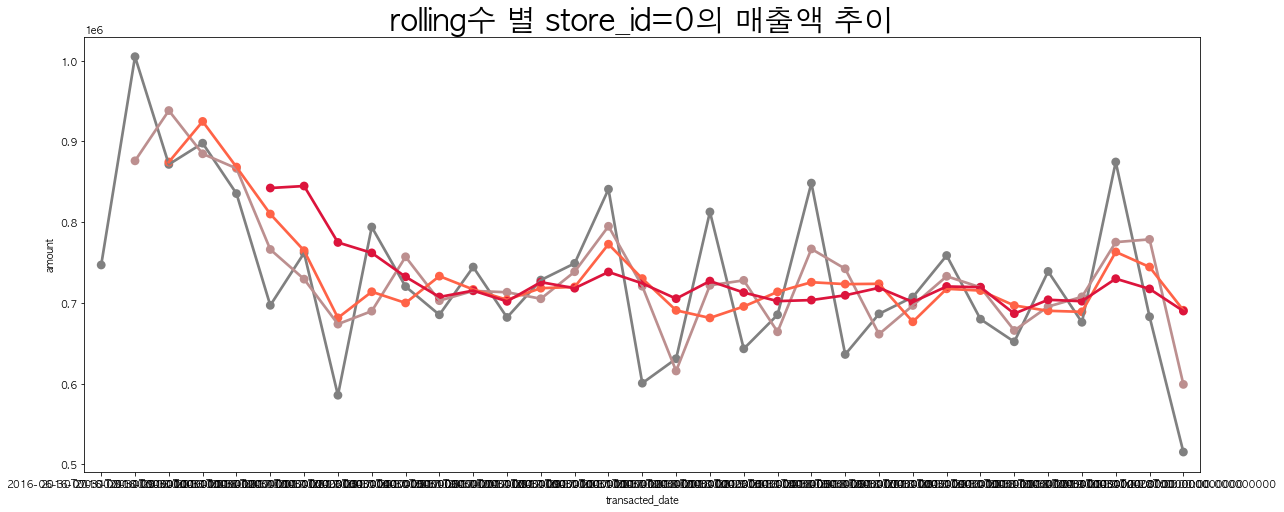

In [391]:
fig,ax=plt.subplots()
fig.set_size_inches(20,8)
sns.pointplot(df_month[df_month.store_id == 0].index, df_month[df_month.store_id == 0].amount,color='grey')
sns.pointplot(df_month.query('store_id==0')['amount'].rolling(2).mean().index ,df_month.query('store_id==0')['amount'].rolling(2).mean().values,color='rosybrown')
sns.pointplot(df_month.query('store_id==0')['amount'].rolling(3).mean().index ,df_month.query('store_id==0')['amount'].rolling(3).mean().values,color='tomato')
sns.pointplot(df_month.query('store_id==0')['amount'].rolling(6).mean().index ,df_month.query('store_id==0')['amount'].rolling(6).mean().values,color='crimson')
plt.title('rolling수 별 store_id=0의 매출액 추이',fontsize=30)
plt.show()

* 기존 매출액(회색) 보다 rolling했을 때(붉은 계열)의 추이가 좀더 완만한 형태를 보임.

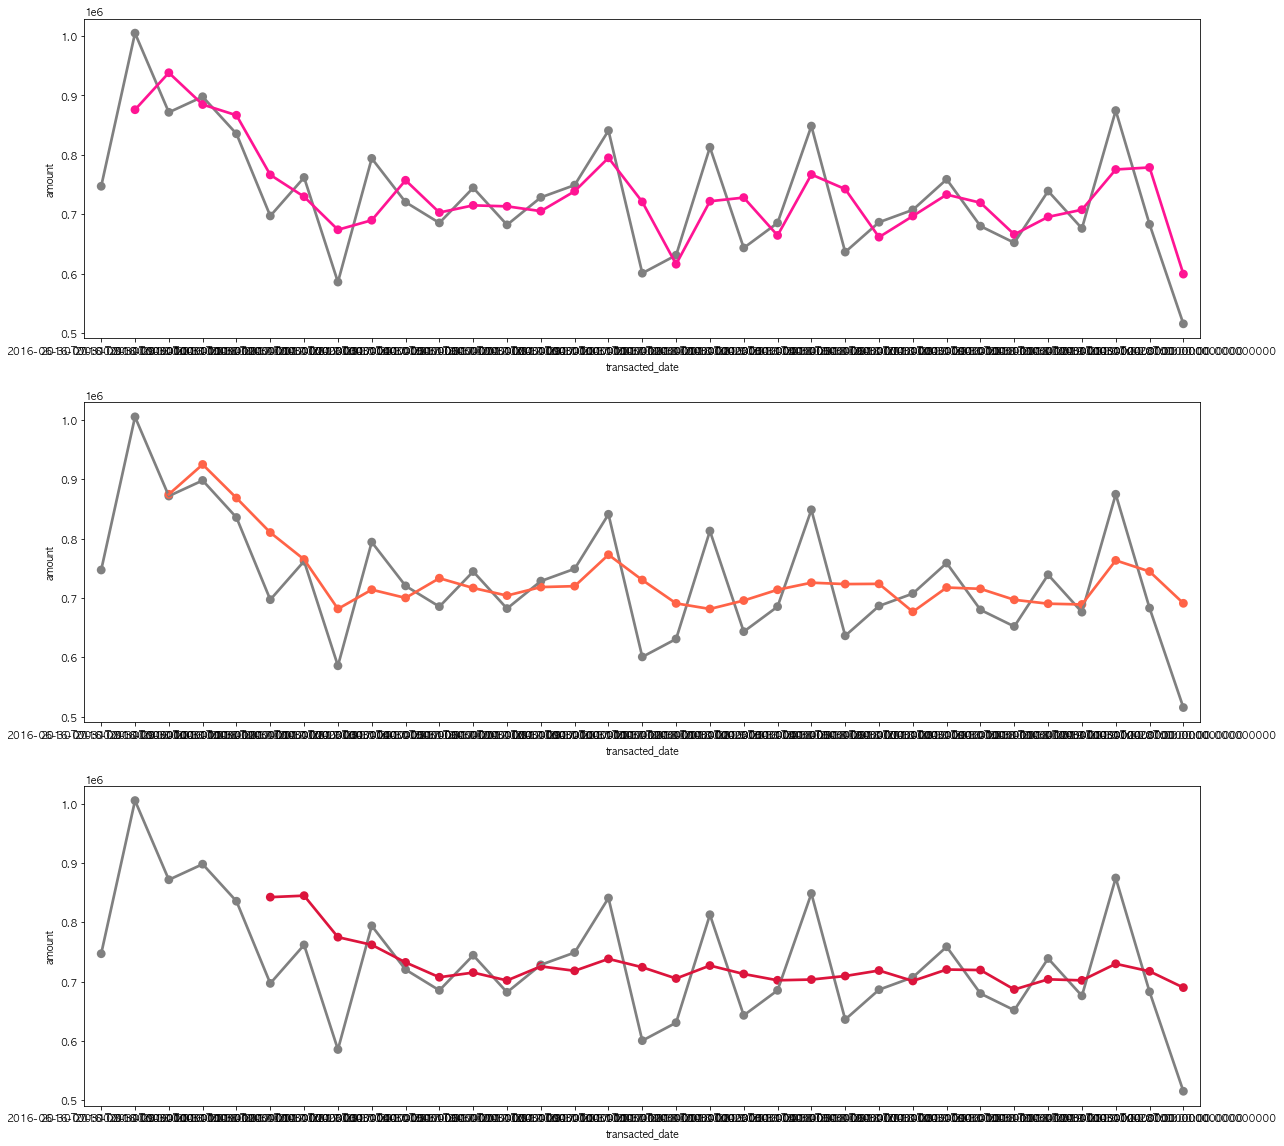

In [392]:
fig, (ax1,ax2,ax3)=plt.subplots(nrows=3)
fig.set_size_inches(20,20)
sns.pointplot(df_month[df_month.store_id == 0].index, df_month[df_month.store_id == 0].amount,color='grey',ax=ax1)
sns.pointplot(df_month.query('store_id==0')['amount'].rolling(2).mean().index ,df_month.query('store_id==0')['amount'].rolling(2).mean().values,color='deeppink',ax=ax1)

sns.pointplot(df_month[df_month.store_id == 0].index, df_month[df_month.store_id == 0].amount,color='grey',ax=ax2)
sns.pointplot(df_month.query('store_id==0')['amount'].rolling(3).mean().index ,df_month.query('store_id==0')['amount'].rolling(3).mean().values,color='tomato',ax=ax2)

sns.pointplot(df_month[df_month.store_id == 0].index, df_month[df_month.store_id == 0].amount,color='grey',ax=ax3)
sns.pointplot(df_month.query('store_id==0')['amount'].rolling(6).mean().index ,df_month.query('store_id==0')['amount'].rolling(6).mean().values,color='crimson',ax=ax3)

plt.show()

In [393]:
# store_id별로 rolling시킨 데이터
def make_sma_arr(window_num):
    ma_arr=np.array([])
    for i in df_month.store_id.unique():
        df_set=df_month[df_month.store_id==i]
        ma_arr=np.concatenate((ma_arr, df_set.amount.rolling(window=window_num).mean().values))
        
    return ma_arr

* np.concatenate() 함수 = array형태를 붙여주는 함수.

In [403]:
sma_month = df_month.copy()

sma_month.insert(7, 'amount_2ma', make_sma_arr(2))    # 7번째 열에 rolling=2를 적용한 데이터 붙이기.
sma_month.insert(8, 'amount_3ma', make_sma_arr(3))    # 8번째 열에 rolling=2를 적용한 데이터 붙이기.
sma_month.insert(9, 'amount_6ma', make_sma_arr(6))   #  9번째 열에 rolling=2를 적용한 데이터 붙이기.

In [405]:
sma_month.head(7)

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount,amount_2ma,amount_3ma,amount_6ma
transacted_date,,,,,,,,,,
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000,nan,nan,nan
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000,876000.00000,nan,nan
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857,938285.71429,874523.80952,nan
2016-09-30,0,25,19.00000,160.00000,103.00000,15.00000,897857.14286,884714.28571,924809.52381,nan
2016-10-31,0,26,16.00000,167.00000,115.00000,9.00000,835428.57143,866642.85714,868285.71429,nan
2016-11-30,0,23,15.00000,132.00000,93.00000,21.00000,697000.00000,766214.28571,810095.23810,842309.52381
2016-12-31,0,27,18.00000,145.00000,103.00000,11.00000,761857.14286,729428.57143,764761.90476,844785.71429


In [468]:
sma_month.tail(7)

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount,amount_2ma,amount_3ma,amount_6ma
transacted_date,,,,,,,,,,
2018-08-31,2136,20,16.00000,216.00000,66.00000,0.00000,1222300.00000,1412042.85714,1719028.57143,1983502.38095
2018-09-30,2136,30,20.00000,460.00000,114.00000,0.00000,2775714.28571,1999007.14286,1866600.00000,2054109.52381
2018-10-31,2136,31,23.00000,338.00000,86.00000,0.00000,2012214.28571,2393964.28571,2003409.52381,2023240.47619
2018-11-30,2136,28,20.00000,356.00000,87.00000,0.00000,2135428.57143,2073821.42857,2307785.71429,2013407.14286
2018-12-31,2136,31,21.00000,403.00000,109.00000,0.00000,2427428.57143,2281428.57143,2191690.47619,2029145.23810
2019-01-31,2136,31,23.00000,297.00000,74.00000,3.00000,1873642.85714,2150535.71429,2145500.00000,2074454.76190
2019-02-28,2136,28,20.00000,376.00000,83.00000,0.00000,2227428.57143,2050535.71429,2176166.66667,2241976.19048


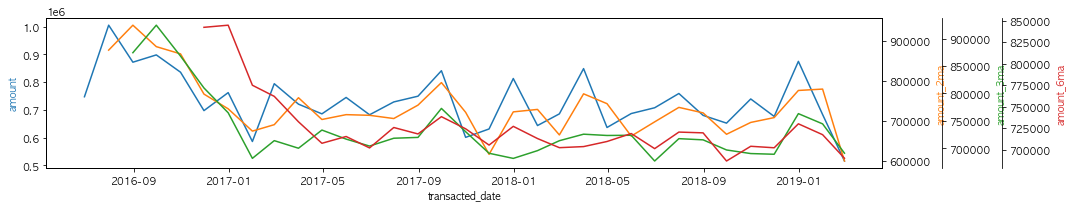

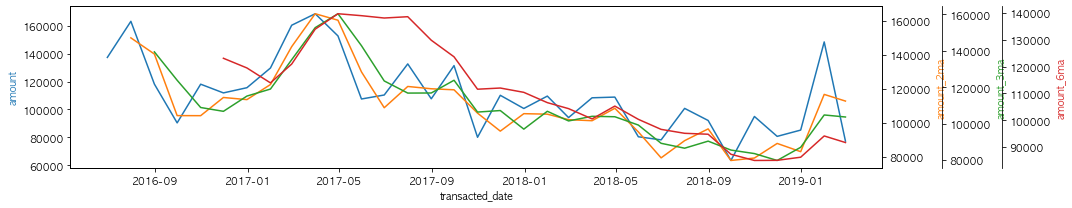

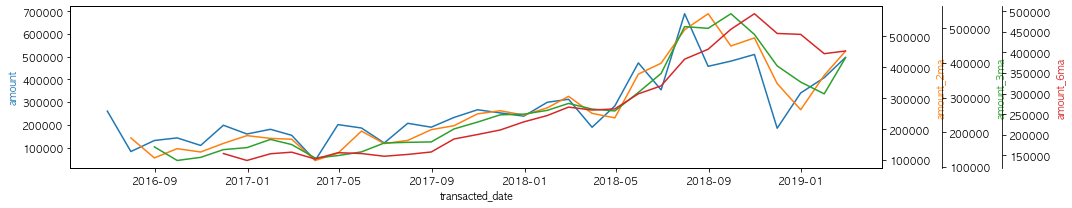

In [406]:
for i in sma_month.store_id.unique()[:3]:
    plot_model_graph(sma_month, i, 'transacted_date', ['amount', 'amount_2ma', 'amount_3ma', 'amount_6ma'])

* store_id=0,1,2인 세가지경우만 예시로 봤을 때
    * rolling=6을 적용한 빨간색 선이 다른색 선들에 비해 완만한 형태를 보임. 

In [407]:
# nan값은 0으로 채워줌. 
print("2 winodw SMA MAE Score : ", mae(sma_month.amount_2ma.fillna(0), sma_month.amount.values))
print("3 window SMA MAE Score : ", mae(sma_month.amount_3ma.fillna(0), sma_month.amount.values))
print("6 window SMA MAE Score : ", mae(sma_month.amount_6ma.fillna(0), sma_month.amount.values))

2 winodw SMA MAE Score :  180687.25906004856
3 window SMA MAE Score :  251607.45528312284
6 window SMA MAE Score :  387465.0993765708


* 원본 매출액과 이동평균을 한 매출액 간의 MAE(평균절대오차)를 확인한 결과
    * 6window일 경우의 MAE가 가장 큼. 

> rolling의 경우, window 3를 예를 들면 t 시점에 대한 값으로 t시점, t-1시점, t-2시점의 평균을 사용한다. <br>
우리가 필요한 것은 t시점을 위해 t-1, t-2, t-3의 평균을 구하는 것이므로 함수를 생성하여 진행
* ex ) rolling 이 3일경우, rolling한 데이터의 맨끝값 이용
    * a = 맨끝 세개의 평균
    * b = 맨끝 두개와 a의 평균
    * c = 맨끝 한개와 a와 b의 평균
    * 최종매출액 = a+b+c (3개월매출 총합이므로 sum)

In [429]:
# values[-3:] => 끝에 3개 데이터만
pd.DataFrame(df_month[df_month.store_id == 0].amount).values[-3:]

array([[874571.42857143],
       [682857.14285714],
       [515285.71428571]])

In [430]:
# 맨끝 3개의 평균
np.average(pd.DataFrame(df_month[df_month.store_id == 0].amount).values[-3:])

690904.7619047619

In [431]:
# values[-2:] => 끝에 2개 데이터만
pd.DataFrame(df_month[df_month.store_id == 0].amount).values[-2:]

array([[682857.14285714],
       [515285.71428571]])

In [434]:
np.append(pd.DataFrame(df_month[df_month.store_id == 0].amount).values[-2:],
        np.average(pd.DataFrame(df_month[df_month.store_id == 0].amount).values[-3:]))

array([682857.14285714, 515285.71428571, 690904.76190476])

In [464]:
# 예시로 살펴보려고 
    def minus_shift_rolling(df_num, num):
        a = np.average(df_num.values[-num:])     # rolling이 3이라고했을때, 맨끝 3개의 평균
        b = np.average(np.append(pd.DataFrame(df_month[df_month.store_id == 0].amount).values[-(num-1):], a))    # 맨끝 2개와 맨끝 3개의 평균을 append하고 그것의 평균을 냄.
        if num > 2:   # rolling이 2보다 크면,
            c = np.average(np.append(np.append(pd.DataFrame(df_month[df_month.store_id == 0].amount).values[-(num-2):], a), b))   # 맨끝 1개와 맨끝3개 평균을 append하고, b를 append하여 평균냄
        else:
            c = np.average((a, b))
        #return np.sum((a, b, c))
        return(a,b,c)

In [465]:
# a,b,c값 따로 
minus_shift_rolling(pd.DataFrame(df_month[df_month.store_id == 0].amount),2)

(599071.4285714286, 557178.5714285715, 578125.0)

In [445]:
#### rolling한 데이터를 store_id 별로 어떻게 집계하는지에 대한 코드같은데 이해가안감..

def make_minus_rolling(data_frame, rolling_num):
    def minus_shift_rolling(df_num, num):
        a = np.average(df_num.values[-num:])     # rolling이 3이라고했을때, 맨끝 3개의 평균
        b = np.average(np.append(df_set.values[-(num-1):], a))    # 맨끝 2개와 맨끝 3개의 평균을 append하고 그것의 평균을 냄.
        if num > 2:   # rolling이 2보다 크면, 즉 3이상
            c = np.average(np.append(np.append(df_set.values[-(num-2):], a), b))   # 맨끝 1개와 맨끝3개 평균을 append하고, b를 append하여 평균냄
        else:
            c = np.average((a, b))
        return np.sum((a, b, c))     # 문제에서 요구하는것이 store_id별 3달치 합계이므로 sum

################################
    minus_rolling_arr = np.array([])
    for i in data_frame.store_id.unique():
        df_set = pd.DataFrame(data_frame[data_frame.store_id == i].amount)
        minus_rolling_arr = np.concatenate((minus_rolling_arr, np.array([minus_shift_rolling(df_set, rolling_num)])))
        
    df_rolling = pd.DataFrame({'store_Id' : df_sub.store_id, 'amount' : minus_rolling_arr})
    
    return df_rolling

In [409]:
make_minus_rolling(df_month, 2)

,store_Id,amount
0,0,1734375.00000
1,1,312000.00000
2,2,1390446.42857
3,4,2717250.00000
4,5,767464.28571
...,...,...
1962,2132,1824589.28571
1963,2133,312535.71429
1964,2134,546857.14286
1965,2135,1278107.14286


In [470]:
# 엑셀로 저장.
for i in range(2, 5):
    df_rolling = make_minus_rolling(df_month, i)
    df_rolling.to_csv('./data/sub/funda_{}_rolling_sub.csv'.format(i), index=False)

* SMA 2 rolling Score : 836184.506520
* SMA 3 rolling Score : 831158.397180    (rolling=3의 경우가 가장 낮게나옴.)
* SMA 4 rolling Score : 854300.339380

------------------------------------------------------------------------------------------------------------------------------------
## 2. 지수이동평균 (Exponential Moving Average)
[참고]
https://www.cmegroup.com/ko/education/learn-about-trading/courses/technical-analysis/understanding-moving-averages.html <br>

### $EMA_t = D_t * \frac{2}{N+1} + EMA_{t-1} * (1- \frac{2}{N+1})$

* 지수이동평균은 가중이동평균 중의 하나로 단순이동평균보다 최근의 데이터에 높은 가중치를 부여하는 방법이다.
* N이 작을수록 최근 데이터를 많이 반영한다.

> 풀이 특징
* 아래 풀이를 보면, 지수이동평균으로 예측한 3달치는 모두 동일한값이고 이를 sum()해서 store_id별로 할당함.

In [473]:
def make_ewm_arr(data_frame, span_num):
    arr_ewm = np.array([])
    for i in data_frame.store_id.unique():
        df_set = data_frame[data_frame.store_id == i]
        # 여기에서 지정하는 span값은 위 수식에서 N에 해당한다.
        arr_ewm = np.concatenate((arr_ewm, df_set.amount.ewm(span=span_num).mean().values))
    
    return arr_ewm

In [476]:
make_ewm_arr(df_month, 3)

array([ 747000.        ,  919000.        ,  891897.95918367, ...,
       2271350.67533149, 2072496.67141619, 2149962.63989171])

In [474]:
ewm_month = df_month.copy()

ewm_month.insert(7, 'amount_3ewm', make_ewm_arr(df_month, 3))
ewm_month.insert(8, 'amount_6ewm', make_ewm_arr(df_month, 6))

In [475]:
ewm_month.head(3)

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount,amount_3ewm,amount_6ewm
transacted_date,,,,,,,,,
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000,747000.00000,747000.00000
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000,919000.00000,897500.00000
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857,891897.95918,885844.03670


In [507]:
ewm_month.tail(3)

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount,amount_3ewm,amount_6ewm
transacted_date,,,,,,,,,
2018-12-31,2136,31,21.00000,403.00000,109.00000,0.00000,2427428.57143,2271350.67533,2194580.15154
2019-01-31,2136,31,23.00000,297.00000,74.00000,3.00000,1873642.85714,2072496.67142,2102805.43256
2019-02-28,2136,28,20.00000,376.00000,83.00000,0.00000,2227428.57143,2149962.63989,2138433.76961


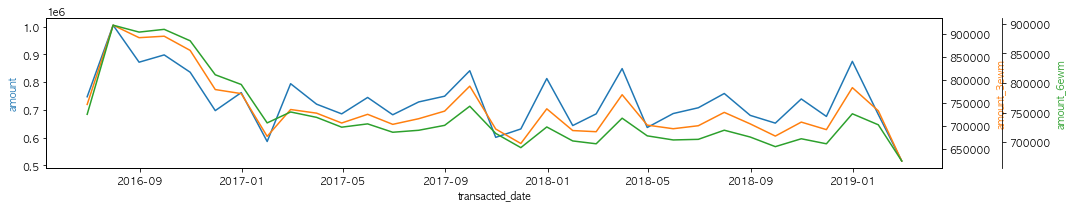

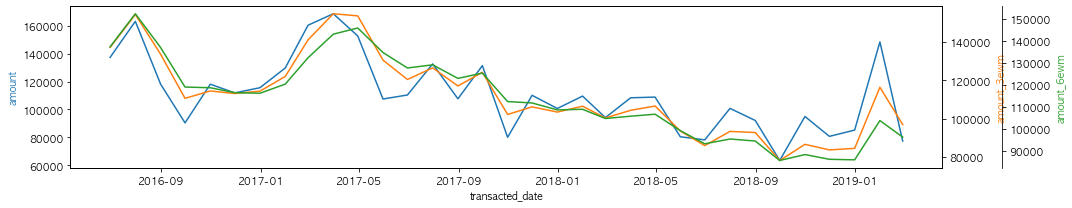

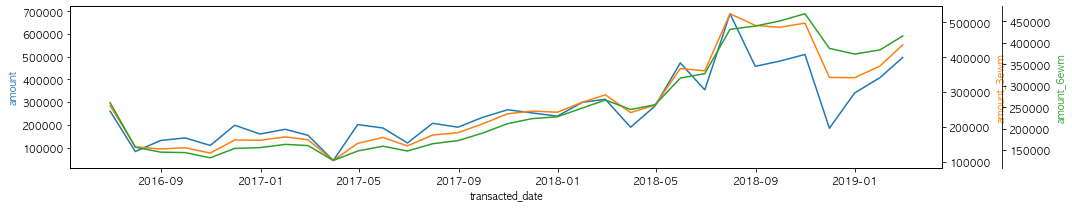

In [477]:
for i in ewm_month.store_id.unique()[:3]:
    plot_model_graph(ewm_month, i, 'transacted_date', ['amount', 'amount_3ewm', 'amount_6ewm'])

In [478]:
# 계산식으로는 N이 작을수록 최근 데이터를 많이 반영.
print("3 N EWM MAE Score : ", mae(ewm_month.amount_3ewm, sma_month.amount.values))
print("6 N EWM MAE Score : ", mae(ewm_month.amount_6ewm, sma_month.amount.values))

3 N EWM MAE Score :  134855.11946915495
6 N EWM MAE Score :  193447.63093078104


In [480]:
# wma_train
pd.concat([pd.DataFrame(df_month[df_month.store_id==0].amount), pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))],axis=0)

,amount
2016-06-30,747000.00000
2016-07-31,1005000.00000
2016-08-31,871571.42857
2016-09-30,897857.14286
2016-10-31,835428.57143
2016-11-30,697000.00000
2016-12-31,761857.14286
2017-01-31,585642.85714
2017-02-28,794000.00000
2017-03-31,720257.14286


Q : 지수이동평균으로 예측한 3일치가 모두 값이 동일한 이유?

In [495]:
# num_sub 의 sum()하기전
pd.concat([pd.DataFrame(df_month[df_month.store_id==0].amount), pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))],axis=0).ewm(span=3).mean()['2019-03':]

,amount
2019-03-31,624220.13070
2019-04-30,624220.13070
2019-05-31,624220.13070


In [489]:
# 예측한 세달치의 합계를 array형태로.
np.concatenate((np.array([]),pd.concat([pd.DataFrame(df_month[df_month.store_id==0].amount), pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))],axis=0).ewm(span=3).mean()['2019-03':].sum()))

array([1872660.39209917])

In [505]:
def make_wma_sub(data_frame, span_num):
    concat_3mon = pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))    # 예측해야 할 날짜 
    wma_sub = np.array([])

    for i in df_month.store_id.unique():
        df_set = pd.DataFrame(data_frame[data_frame.store_id == i].amount)   # store_id별 매출액 dataframe
        wma_train = pd.concat([df_set, concat_3mon], axis=0)    # store_id별 매출액 아래에 예측할 index를 붙임.

        num_sub = np.array([wma_train.amount.ewm(span=span_num).mean()['2019-03':].sum()])   # 지수이동평균으로 구한 3달치의 sum

        wma_sub = np.concatenate((wma_sub, num_sub))     # 3달치 sum한 값을 array형태로
        
    df_wma_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : wma_sub})    # store_id컬럼은 submissoin파일의 store_id
    
    return df_wma_sub

In [506]:
make_wma_sub(df_month, 3)

,store_id,amount
0,0,1872660.39210
1,1,290720.32123
2,2,1307098.14872
3,4,2696538.20977
4,5,850836.82641
...,...,...
1962,2132,1836686.61605
1963,2133,309135.12078
1964,2134,430975.44836
1965,2135,1396125.80508


In [500]:
for i in range(2, 7):
    wma_sub = make_wma_sub(df_month, i)
    wma_sub.to_csv('./data/sub/funda_{}wma_sub.csv'.format(i), index=False)

* 2 span 제출 Score : 820102.106670
* 3 span 제출 Score : 785488.281930
* 4 span 제출 Score : 770667.895320<br>
<br>
* 5 span 제출 Score : **767498.551420**  (N=5일때의 MAE가 가장 낮게나옴)
    * 최근 데이터를 많이 반영한다고해서 결과가 좋은것은 아님. <br>
<br>
* 6 span 제출 Score : 770414.027040

----------------------------------------------------------------------------------------------------
## 3. 지수 평활법 (Exponential Smoothing) - Simple, Holt's, Holt-Winter's
### 3-1) Simple Exponential Smoothing
추세나 계절성 패턴이 없는 데이터를 예측할 때 쓰기 좋다.

### $F_t + \alpha (D_{t-1}-F_{t-1})$ 
###     = $\alpha D_{t-1} + (1-\alpha)F_{t-1}$

> * $F_t$ : 현재 시점의 예측 값
* $F_{t-1}$ : 이전 시점의 예측 값
* $D_{t-1}$ : 이전 시점의 실제 값
* $\alpha$ : smoothing요소 , 0 < $\alpha$ < 1

[ 지수평활법의 특징 ] 
> 1. 단기간에 발생하는 불규칙 변동을 평활하는 방법
2. 지수평활법에서 가중치의 역할을 하는 것은 $\alpha$이며, 불규칙변동이 큰 시계열의 경우 지수평활계수는 작은 값을,<br>
불규칙변동이 작은 시계열의 경우, 큰 값의 지수평활계수를 적용함
3. 지수평활계수는 예측오차(실제 관측치와 예측치 사이의 잔차제곱합) 를 비교하여 예측오차가 가장 작은 값을 선택하는 것이 바람직함
    * 예측하고자 하는 값 이전의 실제값과 이전의 예측값 사이의 잔차제곱합을 통해 최적의 $\alpha$값을 정한다
4. 지수평활법은 불규칙변동의 영향을 제거하는 효과가 있음.

=> 합격자의 경우는 $\alpha =0.9$ 를 사용




### 3-2) Holt's Exponential Smoothing
홀트의 선형 추세 기법 <br>
https://otexts.com/fppkr/holt.html 

> * trend로 데이터를 예측하기 위해 Simple Exponential Smoothing에서 확장한 것이다.
* 예측을 위한 식 외에 level smoothing을 위한 식과 trend smoothing을 위한 식이 포함된다
* 생성된 예측은 선형적으로 나타나기 때문에 예측 범위가 멀어질 수록 over-forecast 되는 경향이 있다.
    * 감쇠홀트기법 : over-forecast를 보완할 방법
        * 미래 어느 시점에 추세를 평평하게 감쇠시키는 한 가지 매개변수를 도입하여 감쇠하는 추세(damped trend)를 포함하는 기법

### $\hat y_{t+h|t} = l_t + hb_t$   
### $l_t = \alpha y_t + (1-\alpha)(l_{t-1}+b_{t-1})$ 
### $b_t = \beta * (l_t - l_{t-1}) + (1-\beta *)b_{t-1}$


> * $l_t$: t 시점에서의 level(수준)의 추정을 나타낸다.
* $b_t$: t 시점에서의 추세(경사)의 추정을 나타낸다.
* $\alpha$ level(수준)에 대한 smoothing parameter이고 다음과 같음 범위를 갖는다. 0 < 𝛼 < 1
* $\beta *$ : trend(추세)에 대한 smoothing parameter이고 다음과 같은 범위를 갖는다. 0 < 𝛽∗< 1
* level에 대한 식 $l_t$ 는 t 시간에 대한 관측치 𝑦𝑡 와 훈련 예측 𝑙𝑡−1+𝑏𝑡−1의 가중 평균을 나타낸다.
* trend에 대한 식 𝑏𝑡 는 (𝑙𝑡−𝑙𝑡−1)에 근거한 t시간에 대한 추정치와 이전 추정치인 𝑏𝑡−1의 가중 평균을 나타낸다.

### 3-3) Holt-Winter's Exponential Smoothing
홀트-윈터스의 계절성 기법 <br>
https://otexts.com/fppkr/holt-winters.html

* Holt-Winter's 방법은 seasonality를 반영하기 위해 Holt's 방법에서 확장된 것이다.
* Holt-Winter's 방법은 예측식과 3개의 smoothing 식으로 구성되어 있다.
    * level에 대한 식  $𝑙_𝑡$
    * trend에 대한 식  𝑏−𝑡
    * seasonal에 대한 요소  $𝑠_𝑡$
    * smoothing parameter에 해당하는  𝛼, 𝛽∗,  𝛾

* seasonality의 빈도를 나타내기 위한  𝑚 (분기별 데이터에서는 m=4, 월별 데이터에서는 m=12)
    * seasonal이 변화하는 형태에 따라 두 가지 방법이 있다.
    * additive : seasonal의 변화가 일정하게 지속될 때
    * multiplicative : seasonal의 변화가 level에 비례적일 때

#### Forecast equation
$𝑦̂_{𝑡+ℎ|𝑡}=𝑙_𝑡+ℎ𝑏_𝑡+𝑠_{𝑡+ℎ−𝑚(𝑘+1)}$
 
#### Level equation
$𝑙_𝑡=𝛼(𝑦_𝑡−𝑠_{𝑡−𝑚})+(1−𝛼)(𝑙_{𝑡−1}+𝑏{𝑡−1})$

#### Trend equation
$𝑏_𝑡=𝛽∗(𝑙_𝑡−𝑙_{𝑡−1})+(1−𝛽∗)𝑏_{𝑡−1}$
 
#### Seasonal equation
$𝑠_𝑡=𝛾(𝑦_𝑡−𝑙_{𝑡−1}−𝑏_{𝑡−1})+(1−𝛾)𝑠_{𝑡−𝑚}$

----------------------------------------------------------------------------------------------------------------------
### 단순 지수평활법 (Simple Exponential Smoothing) 구현

In [515]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [511]:
# store_id=0 의 총 row 수의 70%만 size로 지정.
int(len(df_month[df_month.store_id==0])*0.7)

23

In [521]:
len(test )

10

In [530]:
df_set = df_month[df_month.store_id == 0]   

size = int(len(df_set) * 0.7)  # store_id=0 의 총 row 수의 70%를 size로 지정.
train = df_set[:size]     # 70%는 train - set
test = df_set[size:]     # 나머지 30%는 test-set

ses_model = SimpleExpSmoothing(train.amount)
ses_result = ses_model.fit()
ses_pred = ses_result.forecast(len(test))

In [533]:
ses_pred

2018-05-31   747900.34833
2018-06-30   747900.34833
2018-07-31   747900.34833
2018-08-31   747900.34833
2018-09-30   747900.34833
2018-10-31   747900.34833
2018-11-30   747900.34833
2018-12-31   747900.34833
2019-01-31   747900.34833
2019-02-28   747900.34833
Freq: M, dtype: float64

Q : 예측한값이 왜 다 똑같이나오는이유..? <br>
A : 직전의 실제값이 없어서??
    * alpha x 직전의 실제값 + (1-alpha) x 직전의 예측값

In [522]:
print("store_id 0 mean value : ", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, ses_pred))

store_id 0 mean value :  732559.7402597402
MAE Score of test : 78211.6375674183


In [524]:
def plot_train_test_pred_graph(trainset, testset, pred):
    plt.figure(figsize=(15,3))
    plt.plot(trainset.amount, label='train')
    plt.plot(testset.amount, label='test')
    plt.plot(testset.index, pred, label='prediction')
    plt.legend()
    plt.show()

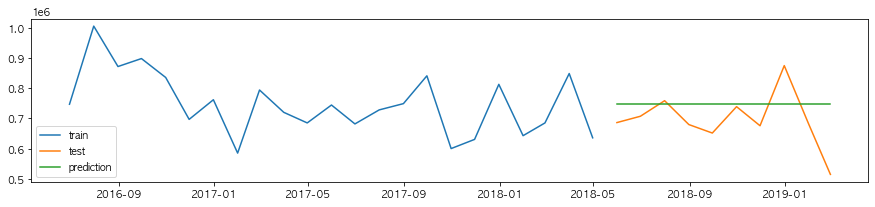

In [525]:
plot_train_test_pred_graph(train, test, ses_pred)

In [526]:
np.concatenate((np.array([]), np.array([ses_pred.sum()])))

array([7479003.4832665])

In [529]:
ses_pred_arr = np.array([])
for i in df_month.store_id.unique():
    df_set = df_month[df_month.store_id == i]
    
    ses_model = SimpleExpSmoothing(df_set.amount)
    ses_result = ses_model.fit()
    ses_pred = ses_result.forecast(3)    # 세달 예측이므로 3대입
    
    ses_pred_arr = np.concatenate((ses_pred_arr, np.array([ses_pred.sum()])))

In [537]:
# store_id별 매출액을 아래 submission파일의 store_id에다가 매칭.
ses_pred_arr

array([2071584.36386419,  287862.91614294, 1271010.79096992, ...,
        425286.89975373, 1631665.25359906, 6472160.40383348])

In [541]:
df_ses_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : ses_pred_arr})

In [542]:
df_ses_sub.head()

,store_id,amount
0,0,2071584.36386
1,1,287862.91614
2,2,1271010.79097
3,4,2676109.28287
4,5,715800.20502


* Simple Exponential Smoothing Score : 818205.82245

### 홀트의 선형 추세 기법 (Holt's Exponential Smoothing) 구현


In [543]:
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

holt_model = Holt(np.array(train.amount))
holt_result = holt_model.fit()
holt_pred = holt_result.forecast(len(test))

Mean value of store_id 0 :  732559.7402597402
MAE Score of test : 104762.75933861136


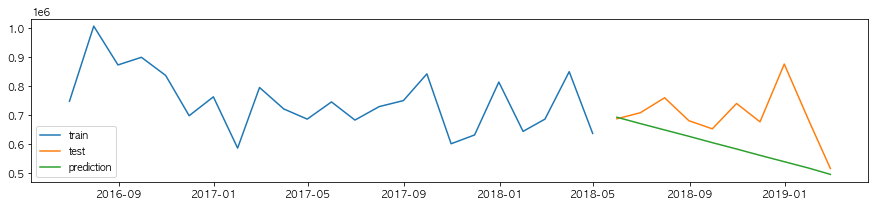

In [544]:
print("Mean value of store_id 0 : ", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, holt_pred))

plot_train_test_pred_graph(train, test, holt_pred)

In [545]:
holt_pred_arr = np.array([])
for i in df_month.store_id.unique():
    df_set = df_month[df_month.store_id == i]
    
    holt_model = Holt(np.array(df_set.amount))
    holt_result = holt_model.fit()
    holt_pred = holt_result.forecast(3)
    
    holt_pred_arr = np.concatenate((holt_pred_arr, np.array([holt_pred.sum()])))

In [546]:
holt_sub = pd.DataFrame({'sotre_id' : df_sub.store_id, 'amount' : holt_pred_arr})

* Holt's Exponential Smoothing Score : 926470.756080

### 홀트-윈터스의 계절성 기법 (Holt-Winter's Exponential Smoothing)
* 합격자의 경우 덧셈기법과 곱셈기법 중 덧셈기법을 사용.

In [560]:
len(test)

10

In [561]:
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

# 최적값을 찾기 위한 기준
es_score = 1000000000
best_period = 0

# 각 store_id 별 최적의 seasonal period를 찾기 위한 탐색
### 분기별로 할지(=4), 월별로 할지(=12)
for p in range(2,(len(train)//2) + 1):
    try:
        es_model = ExponentialSmoothing(np.array(train.amount), seasonal_periods=p, trend='add', seasonal='add')
        es_result = es_model.fit()
        es_pred = es_result.forecast(len(test))

        if es_score > mae(test.amount, es_pred):
            es_score = mae(test.amount, es_pred)
            best_period = p
    except:
        continue

In [562]:
p

11

Mean value of store_id 0 : 732559.7402597402
MAE Score of test : 63279.99370008393
Best seasonal period : 4


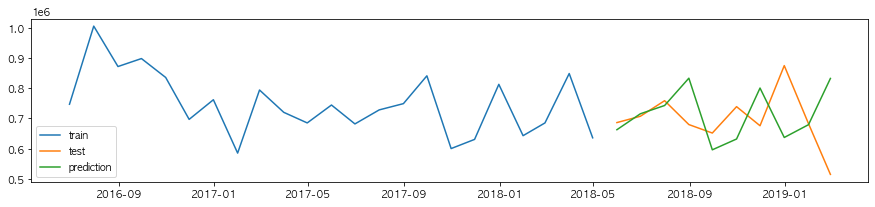

In [563]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("MAE Score of test :", es_score)
print("Best seasonal period :", best_period)

plot_train_test_pred_graph(train, test, es_pred)

In [564]:
holt_winters_arr = np.array([])
for i in df_month.store_id.unique():
    df_set = df_month[df_month.store_id == i]

    size = int(len(df_set) * 0.7)
    train = df_set[:size]
    test = df_set[size:]
    
    # 최적값을 찾기 위한 기준
    es_score = 1000000000
    best_period = 0
    # 각 store_id 최적의 seasonal period를 찾기 위한 탐색
    ### 분기별로 할지(=4), 월별로 할지(=12)
    for p in range(2,(len(train)//2) + 1):
        try:
            es_model = ExponentialSmoothing(np.array(train.amount),seasonal_periods=p, trend='add', seasonal='add')
            es_result = es_model.fit()
            es_pred = es_result.forecast(len(test))

            if es_score > mae(test.amount, es_pred):
                es_score = mae(test.amount, es_pred)
                best_period = p
        except:
            continue
    
    # 최적의 parameter을 이용한 3개월 예측과 sum
    ### store_id별로 seasonal_periods를 다르게 적용.
    set_es_model = ExponentialSmoothing(np.array(df_set.amount), seasonal_periods=best_period, trend='add', seasonal='add')
    set_es_result = set_es_model.fit()
    set_es_pred = set_es_result.forecast(3)
    
    holt_winters_arr = np.concatenate((holt_winters_arr, np.array([set_es_pred.sum()])))

In [565]:
 set_es_pred

array([2712268.15783179, 2081459.67899292, 2152096.63246941])

In [566]:
holt_winters_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : holt_winters_arr})
holt_winters_sub.to_csv('./data/sub/funda_holt_winters_sub.csv', index=False)

* Holt-Winter's Exponential Smoothing Score : 962259.599880

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
## 4. ARMA
* 많은 store_id들이 정상성을 만족하지 않으므로, 아래에 ARIMA로 진행예정.
* ARMA(p,q) 모형은 AR(p) 모형과 MA(q) 모형의 특징을 모두 가지는 모형이다.
    * 즉, p개의 자기 자신의 과거값과 q개의 과거 백색 잡음의 선형 조합으로 현재의 값이 정해지는 모형이다. <br>
$𝑌_𝑡=−𝜙_1𝑌_{𝑡−1}−𝜙_2𝑌_{𝑡−2}−⋯−𝜙_𝑝𝑌_{𝑡−𝑝}+𝜖_𝑡+𝜃_1𝜖_{𝑡−1}+𝜃_2𝜖_{𝑡−2}+⋯+𝜃_𝑞𝜖_{𝑡−𝑞}$

많은 store_id들이  |𝜙|<1의 AR 정상상태(stationary) 조건에 맞지 않아 1 이상의 p 값을 적용할 수 없다. <br>
따라서 차분(difference)을 이용해 비정상상태(non-stationary)의 설명이 가능한 ARIMA를 추가로 진행한다.

----------------------------------------------------------------------------------------------------
## **정상시계열과 비정상 시계열의 특징**

### 정상성 
* 언제 관찰하는지에 상관이 없고, 시간에 따라 어떤 시점에서 보더라도 똑같이 보임.
* 추세나 계절성이 있는 시계열은 정상성을 나타내는 시계열이 아님. 
    * 주기성 행동을 가지고 있는 (하지만 추세나 계졀성은 없는) 시계열은 정상성을 나타내는 시계열이다.
    
        * 1) 평균이 일정 : 모든 시점에 대해 일정한 평균을 가진다.
                 - 평균이 일정하지 않은 시계열은 차분을 통해 정상화
                     - 차분은 현시점 자료에서 이전 시점 자료를 빼는 것
        * 2) 분산도 시점에 의존하지 않음
                 - 분산이 일정하지 않은 시계열은 변환을 통해 정상화
        * 3) 공분산도 시차에만 의존할 뿐, 특정 시점에는 의존하지 않음.
                 - 공분산 : 확률변수들이 어떻게 퍼져있는지를 나타냄 (X가 증가할때 Y도 증가하는지, 감소하는지 등)


| 정상시계열 | 비정상시계열 |
| --- | --- |
| * 뚜렷한 추세가 없다 | * 평균수준이 시간대에 따라 다르다. 추세를 가진다. | 
| * 진폭이 시간의 흐름에 따라 일정하다. | * 계절성을 가진다. | 
| * 분산이 변한다. | 

## **시계열 모형 : AR , MA, ARMA, ARIMA 모형, 분해 시계열**
### [1] AR 모형 (자기회귀) : 
시계열 데이터 Yt에서 시점 r의 관측치 Yt가 과거 관측치 Y(t-1), Y(t-2) 들에 의해 설명될 때 AR(p) 모형을 따른다고 한다. <br>
즉, 확률적 추세를 제거하기 위함. 부분 자기상관이 있는 차수의 종속변수를 모형에 반영해서 해당 차수의 확률적 추세가 만드는 불안정성을 제거하는 모형 <br>
=> AR 모형은 백색 잡음의 현재값과 자기 자신의 과거값의 선형 가중합으로 이루어진 정상 확률 모형. <br>
### $Yt = u + a_1Y_{t-1} + a_2Y_{t-2} + ... + a_pY_{t-p} + e_t$ ($e_t$ : 백색잡음)
* white-noise : 평균이 0이고 분산이 1인 정규분포에서 도출된 random한 값

#### AR(1) 모형
* 백색 잡음의 현재값과 1스텝 과거의 자기 자신의 값만의 가중합으로 이루어진 모형. <br>
#### $Y_t = -\phi Y_{t-1} + \epsilon_t$  <br>
(theta는 자기상관계수, epsilon은 white noise)

#### AR(2) 모형
* 백색 잡음의 현재값과 1스텝 과거의 자기 자신의 값, 그리고 2스텝 과거의 자기 자신의 값의 가중합으로 이루어진 모형. <br>
#### $Y_t = -\phi_1 Y_{t-1} -\phi_2 Y_{t-2} + \epsilon_t $

### [2] MA 모형 (이동평균) :
시계열 데이터 Yt에서 시점 r의 관측치 Yt가 과거 오차 e(t-1), e(t-2), 들에 의해 설명될 때 MA(q) 모형을 따른다고 한다.<br>
즉, 불규칙한 변동을 제거하기 위한 모형. <br>
### $Y_t = e_t -\beta_1 e_{t-1} - \beta_2 e_{t-2} - ... -\beta_q e_{t-4}$

#### MA(1) 모형
* 백색 잡음의 현재 값과 1- 시간 지연된 과거 값, 그리고 2-시간 지연된 과거 값의 선형 가중합으로 나타난다. <br>
#### $Y_t = \epsilon_t + \theta_1 \epsilon_{t-1} $ 
(beta는 이동평균계수, epsilon은 t시점의 오차항)

#### MA(2) 모형
* 백색 잡음의 현재 값과 1 스텝 지연된 과거 값의 합이다. <br>
#### $Y_t = \epsilon_t + \theta_1 \epsilon_{t-1} +\theta_2 \epsilon_{t-2}$

### [3] ARMA 모형 :
시계열 데이터 Yt에서 시점 r의 관측치 Yt가 과거 관측치 Y(t-1), Y(t-2) 들과 과거 오차 e(t-1), e(t-2), 들에 의해 설명될 때 ARMA(p,q) 모형을 따른다고 한다.

**ARMA(1,1)모형** <br>
#### $x_t = {a_1 * X_{t-1}} + {b * e_{t-1}} + c + u * e_t$ <br>

**ARMA(2,2) 모형** <br>
#### $x_t = {a_1 * X_{t-1}+ a_2 * X_{t-2}} + {b* e_{t-1} + b2 * e_{t-2}} + c + u * e_t$ <br>
* AR(p) = ARIMA(p,0,0) <br>
* MA(q) = ARIMA(0,0,q) <br>
* ARMA(p,q) = ARIMA(p,0,q) <br>

### [4] ARIMA 모형 (p,d,q)
비정상 시계열 모형. 차분이나 변환을 통해 AR, MA, 또는 ARMA 모형으로 정상화
* p : 자기회귀 차수
* d : 차분 차수
* q : 이동평균 차수

### ※ARMA 와 ARIMA 차이점 :
ARIMA의 경우 시계열의 비정상성을 설명하기 위해 관측치간의 차분을 사용함
* 비정상성을 제거하는 과정을 포함한 것이 ARIMA모형

(+) 상관 함수 : ACF, PACF (ARMA 모형 진단에 사용)

#### AR 모형과 MA모형의 차이
* MA모형은 이전에 발생한 error가 중요한 것이지, X(t-1) 값이 무엇인지는 중요하지 않다.

----------------------------------------------------------------------------------------------------
## **ACF(자기상관 함수), PACF(부분 상관함수)**
* ACF (Auto correlation function) : Lag(시간지연 연산자)에 따른 관측치들 사이의 관련성을 측정하는 함수
* PACF (Partial autocorrelation function) : k이외의 모든 다른 시점 관측치의 영향력을 배제하고 $y_t 와 y_{t-k}$ 두 관측치의 관련성을 측정하는 함수

## **ARMA(p,q)과정의 ACF와 PACF의 이론적인 특성**
| 확률과정 | ACF | PACF |
| --- | --- | --- |
| AR(p) | 지수적으로 감소하거나 소멸하는 싸인함수 형태 | 시차 p이후에는 0으로의 절단형태 |
| MA (q) | 시차 q이후에는 0으로의 절단형태 | 지수적으로 감소하거나 소멸하는 싸인함수 형태 |
| ARMA (p,q) | 시차(q-p)이후에는 지수적으로 감소하거나 소멸하는 사인함수 형태 | 시차(q-p)이후에는 지수적으로 감소하거나 소멸하는 사인함수 형태 |

* ACF가 서서히 감소하고, PACF가 급격히 0에 근접한 값을 가지면 AR(p)모형 선정
* ACF가 급격히 0에 근접한 값을 가지고, PACF가 서서히 감소하면 MA(q)모형 선정
* ACF, PACF 모두 특정 차수 이상에서 없어지는 현상이 나타나지 않는다면 ARMA 모형을 사용해야 한다.

< 차수 결정 방법 >
MA의 차수는 ACF로, AR의 차수는 PACF로 결정.



----------------------------------------------------------------------------------------------------
## Process 정리
https://statkclee.github.io/statistics/stat-time-series-arma.html

* 식별 (Identification) <br>
    시계열이 계절적 특성을 띄는지, 안정적인지 여부를 판단.<br>
    이 과정에서 SARIMA(p,d,q)(P,D,Q)s 모형 가운데 d 와 D 그리고 s 의 값을 결정하게 된다. <br>
    이어서 acf, pacf를 통해 p(AR의차수) 와 q(MA의차수) 그리고 P(SAR의차수), Q(SMA의 차수)값을 추정한다.<br>
<br>
* 추정 (Estimation of Parameter)<br>
    앞선 식별단계를 통해 알아낸 p,d,q,P,D,Q 값들 가운데 통계적으로 가장 적합한 값을 결정한다.<br>
    이와 함께  p,d,q,P,D,Q 값이 정해지면서 결정되는 AR, MA, SAR, SMA각 항들에 대한 모수를 추정하게 된다. <br>
    각 항들의 모수를 추정하는 대표적인 추정법으로는 최대우도 추정법, 최소제곱 추정법, 비선형 추정법 등이 있다.<br>
<br>
* 진단 (Diagnosis)<br>
    추정된 모형에 대한 통계적 진단을 하는 단계. 통계적으로 유의한지 여부와 모형이 과연 예측모형으로써 적절한지 여부.<br>
    주로 잔차분석, 과적합진단 등을 통해 전체 모형을 진단.
        * 잔차가 서로 독립이고, 시간에 따라 평균과 분산이 일정한지 검증.
<br>
* 예측 (Forecasting)<br>
    선택된 최종모델을 활용하여 예측.

In [568]:
import statsmodels.api as sm

In [569]:
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

set_arma = sm.tsa.ARMA(train.amount, (0, 2))
set_result = set_arma.fit()

set_output = set_result.forecast(len(test))
set_pred = set_output[0]

### 1. STL Decomposition (Seasonal Trend Decomposition using Loses)

> store_id=0 과 store_id=2 데이터를 예시로 살펴보자.

In [584]:
from statsmodels.tsa.seasonal import seasonal_decompose

<Figure size 432x288 with 0 Axes>

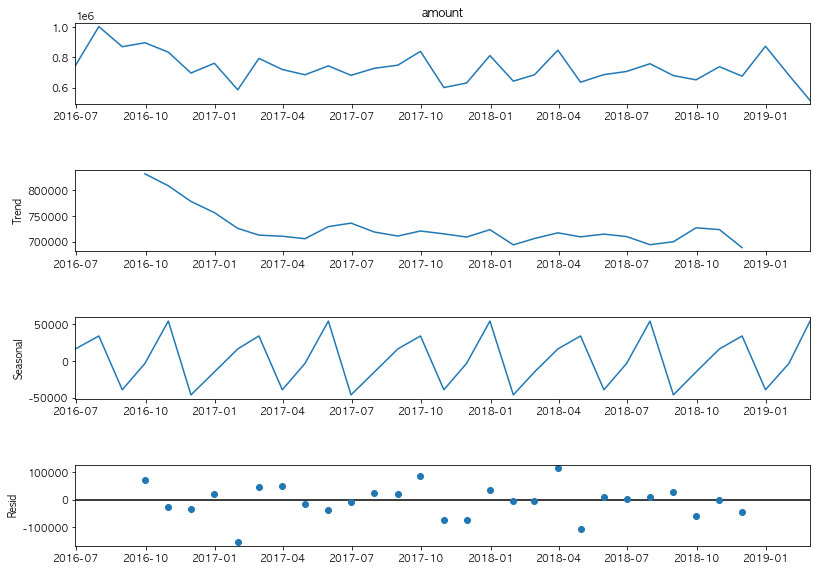

In [587]:
decomposition=seasonal_decompose(df_set['amount'],freq=7)
fig=plt.figure()
fig=decomposition.plot()
fig.set_size_inches(13,9)
plt.show()

<Figure size 432x288 with 0 Axes>

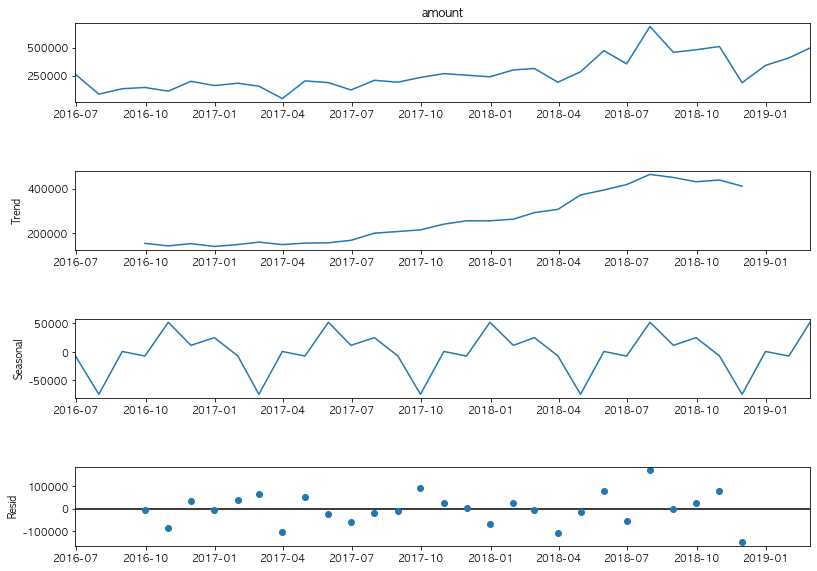

In [595]:
decomposition=seasonal_decompose(df_month[df_month.store_id==2].amount,freq=7)
fig=plt.figure()
fig=decomposition.plot()
fig.set_size_inches(13,9)
plt.show()

### 정상성 검정
https://datascienceschool.net/view-notebook/ebb638fc880145b9adeef8dfa630f067/

**ADF검정 -> 정상성을 알아보기 위한 단위 검정** <br>
Augmented Dickey-Fuller (ADF) 검정은 1차 누적에 의한 확률적 추세뿐 아니라 2차항으로 나타나는 결정론적 추세를 포함하는 시계열에 대해서 <br>
단위 근 검정을 할 수 있도록 DF 검정을 일반화 한 것이다. <br>
ADF 검정도 DF 검정과 마찬가지로 회귀 분석 결과로 나온 계수를 검정 통계량으로 사용

* 귀무가설 : 시계열이 비안정적이다.
* 대립가설 : 시계열이 안정적.

Augmented Dickey-Fuller(ADF) 검정은 1차 누적에 의한 확률적 추세뿐 아니라 2차항으로 나타나는 결정론적 추세를 포함하는 시계열에 대해서 단위근 검정을 할 수 있도록 DF검정을 일반화 한 것이다.

**단위근 검정**

더 객관적으로 차분을 구하는 것이 필요할 지 결정하기 위해 사용하는 한 가지 방법.

**반환값**
* pdf : 검정 통계량
* p-value
* usedlag : 사용된 시차의 수
* nobs :분석에 자료의 수
* critical values : 1%, 5%, 10%수준에 해당되는 검정 통계량의 값

In [596]:
from statsmodels.tsa.stattools import adfuller

In [598]:
# store_id=0의 정상성 검증 
print( "검정통계량:" ,adfuller(df_set['amount'])[0])
print( "p-value:" ,adfuller(df_set['amount'])[1])
print( "사용된 시차의 수:" ,adfuller(df_set['amount'])[2])
print( "자료의 수:" ,adfuller(df_set['amount'])[3])
print( "1%,5%,10%수준에 해당되는 검정통계량의 값:" ,adfuller(df_set['amount'])[4])

검정통계량: -4.062686736375095
p-value: 0.0011155930914035486
사용된 시차의 수: 3
자료의 수: 29
1%,5%,10%수준에 해당되는 검정통계량의 값: {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}


* store_id=0 은 p-value < 0.05 이므로 정상성을 만족

In [602]:
# store_id=2의 정상성 검증 
print( "검정통계량:" ,adfuller(df_month[df_month.store_id==2].amount)[0])
print( "p-value:" ,adfuller(df_month[df_month.store_id==2].amount)[1])
print( "사용된 시차의 수:" ,adfuller(df_month[df_month.store_id==2].amount)[2])
print( "자료의 수:" ,adfuller(df_month[df_month.store_id==2].amount)[3])
print( "1%,5%,10%수준에 해당되는 검정통계량의 값:" ,adfuller(df_month[df_month.store_id==2].amount)[4])

검정통계량: 1.4663162674888486
p-value: 0.9973955327817781
사용된 시차의 수: 8
자료의 수: 24
1%,5%,10%수준에 해당되는 검정통계량의 값: {'1%': -3.7377092158564813, '5%': -2.9922162731481485, '10%': -2.635746736111111}


* store_id=2는 p-value > 0.05 이므로 정상성을 만족하지 않는다.

### ACF, PACF plot

In [603]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

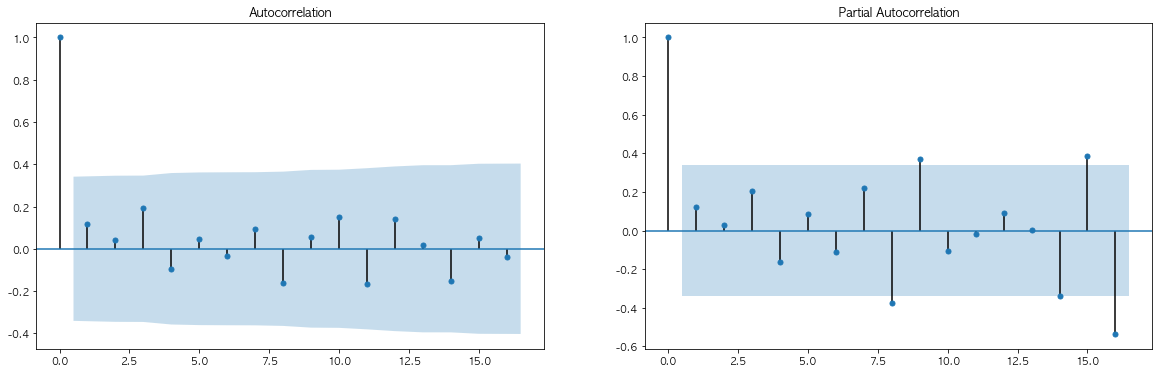

In [609]:
# store_id =0 의 ACF, PACF
fig, ax = plt.subplots(1,2, figsize=(20,6))
plot_acf(df_set['amount'], ax=ax[0])
plot_pacf(df_set['amount'], ax=ax[1]) 
plt.show()

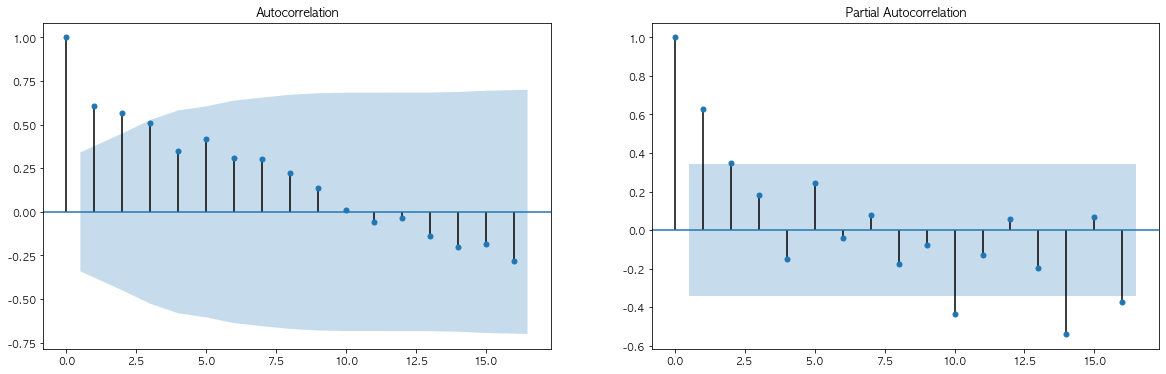

In [606]:
# store_id =2 의 ACF, PACF
fig, ax = plt.subplots(1,2, figsize=(20,6))
plot_acf(df_month[df_month.store_id==2].amount, ax=ax[0])
plot_pacf(df_month[df_month.store_id==2].amount, ax=ax[1]) 
plt.show()

* store_id=2는 PACF가 시차 2이후에는 0으로의 절단형태 => AR(2,0)모형으로 판단

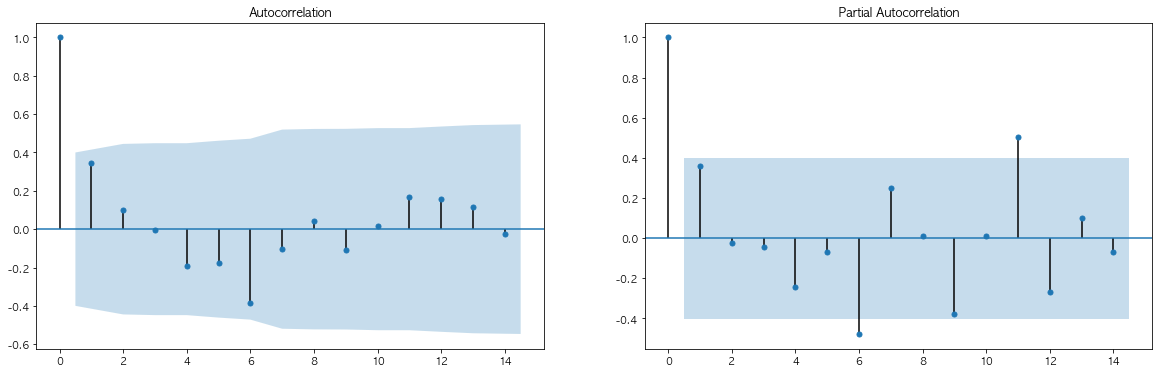

In [624]:
# store_id =22 의 ACF, PACF
fig, ax = plt.subplots(1,2, figsize=(20,6))
plot_acf(df_month[df_month.store_id==22].amount, ax=ax[0])
plot_pacf(df_month[df_month.store_id==22].amount, ax=ax[1]) 
plt.show()

### ARMA모형구축

In [628]:
# ARMA(1,1)
m2 = sm.tsa.ARMA(df_set.amount, (1, 1))
r = m2.fit(disp=False)
print(r.summary())

                              ARMA Model Results                              
Dep. Variable:                 amount   No. Observations:                   33
Model:                     ARMA(1, 1)   Log Likelihood                -426.265
Method:                       css-mle   S.D. of innovations          98411.838
Date:                Sun, 03 May 2020   AIC                            860.531
Time:                        00:43:25   BIC                            866.517
Sample:                    06-30-2016   HQIC                           862.545
                         - 02-28-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7.346e+05   2.82e+04     26.029      0.000    6.79e+05     7.9e+05
ar.L1.amount     0.8185      0.433      1.889      0.059      -0.031       1.668
ma.L1.amount    -0.6962      0.486     -1.43

In [634]:
# AR
m2 = sm.tsa.ARMA(df_set.amount, (1, 0))
r = m2.fit(disp=False)
print(r.summary())

                              ARMA Model Results                              
Dep. Variable:                 amount   No. Observations:                   33
Model:                     ARMA(1, 0)   Log Likelihood                -426.457
Method:                       css-mle   S.D. of innovations          99085.091
Date:                Sun, 03 May 2020   AIC                            858.914
Time:                        14:51:25   BIC                            863.403
Sample:                    06-30-2016   HQIC                           860.424
                         - 02-28-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7.326e+05   1.98e+04     36.993      0.000    6.94e+05    7.71e+05
ar.L1.amount     0.1316      0.184      0.717      0.474      -0.228       0.491
                                    Roots   

In [635]:
# MA
m2 = sm.tsa.ARMA(df_set.amount, (0, 1))
r = m2.fit(disp=False)
print(r.summary())

                              ARMA Model Results                              
Dep. Variable:                 amount   No. Observations:                   33
Model:                     ARMA(0, 1)   Log Likelihood                -426.463
Method:                       css-mle   S.D. of innovations          99104.660
Date:                Sun, 03 May 2020   AIC                            858.927
Time:                        14:51:36   BIC                            863.416
Sample:                    06-30-2016   HQIC                           860.438
                         - 02-28-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7.326e+05   1.95e+04     37.587      0.000    6.94e+05    7.71e+05
ma.L1.amount     0.1317      0.190      0.692      0.489      -0.242       0.505
                                    Roots   

* ARMA(1,1) 
    * AIC = 860.531
* AR(1,0)
    * AIC = 858.914
* MA(0,1)
    * AIC = 858.927

### 모델 진단

----------------------------------------------------------------------------------------------------
## 5. ARIMA
* 합격자의 경우 store_id별로 AIC기준으로 최적의 p,d,q를 구함.
